In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install linearmodels -q

In [ ]:
##################

In [ ]:
# ==============================================================================
# Cell 1: Setup and Configuration
# ==============================================================================
import pandas as pd
import numpy as np
import os
import time
import gc
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Configuration: VERIFY YOUR BASE PATH ---
BASE_PATH = '/content/drive/MyDrive/Master_Thesis_vF/'

# --- Automatically set other paths ---
PROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'Data/processed/')
OUTPUT_PATH = os.path.join(BASE_PATH, 'output/')
OUTPUT_TABLES_PATH = os.path.join(OUTPUT_PATH, 'tables/')
OUTPUT_CHARTS_PATH = os.path.join(OUTPUT_PATH, 'charts/')

print("Setup Complete. All paths configured.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup Complete. All paths configured.


In [ ]:
# ==============================================================================
# Aggreggating all raw files (half-year) into one big csv
# ==============================================================================


import os
import gc
import time
import warnings
from typing import Dict, Any

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# -----------------------------------------------------------------------------
# Configuration – expects BASE_PATH to be defined in the notebook setup cell.
# -----------------------------------------------------------------------------
RAW_FILE  = f"{BASE_PATH}/Data/processed/thesis_data_without_ecbb.csv"
OUT_FILE  = f"{BASE_PATH}/Data/processed/thesis_full_prepared_data.feather"
OUT_FILE_CSV = f"{BASE_PATH}/Data/processed/thesis_full_prepared_data.csv"  # always produced

SPOT_SET: set[str] = {"SPOT", "PM SPOT"}
PASS1_CHUNK        = 1_000_000   # rows per chunk in Pass‑1
PASS2_CHUNK        = 1_000_000   # rows per chunk in Pass‑2
BATCH_SIZE_LIMIT   = 5_000_000   # rows to buffer before writing

# -----------------------------------------------------------------------------
# Pass‑1  ───────────────────────────────────────────────────────────────────────
# -----------------------------------------------------------------------------

def build_best_table() -> pd.DataFrame:
    """Scan the raw CSV once and derive best bid / best ask price per Request ID.
    Returns a DataFrame with *three* columns: [Request ID, best_bid, best_ask]."""

    best: Dict[Any, Dict[str, float]] = {}
    usecols = ["Request ID", "Product", "Bid Quote", "Quote Value"]
    print("--- Starting Pass 1: Finding best bid/ask prices (memory‑safe)...")

    for ck in pd.read_csv(RAW_FILE, usecols=usecols, chunksize=PASS1_CHUNK, low_memory=False):
        ck["Product"] = ck["Product"].str.upper()
        ck["Bid Quote"]  = pd.to_numeric(ck["Bid Quote"],  errors="coerce")
        ck["Quote Value"] = pd.to_numeric(ck["Quote Value"], errors="coerce")
        ck.dropna(subset=["Bid Quote", "Quote Value"], inplace=True)

        is_spot = ck["Product"].isin(SPOT_SET)
        ck["Bid_Price"] = np.where((ck["Bid Quote"] == 1) & (~is_spot | (ck["Quote Value"] > 0)), ck["Quote Value"], np.nan)
        ck["Ask_Price"] = np.where((ck["Bid Quote"] != 1) & (~is_spot | (ck["Quote Value"] > 0)), ck["Quote Value"], np.nan)

        tmp = ck.groupby("Request ID").agg(best_bid=("Bid_Price", "max"),
                                            best_ask=("Ask_Price", "min"))
        for rid, row in tmp.iterrows():
            if rid not in best:
                best[rid] = {"best_bid": row["best_bid"], "best_ask": row["best_ask"]}
            else:
                b = best[rid]
                b["best_bid"] = np.nanmax([b["best_bid"], row["best_bid"]])
                b["best_ask"] = np.nanmin([b["best_ask"], row["best_ask"]])
        del ck, tmp; gc.collect()

    best_df = pd.DataFrame.from_dict(best, orient="index")
    best_df.index.name = "Request ID"        # crucial: give the index a name
    best_df.reset_index(inplace=True)         # ...and make it a real column

    print(f"✓ Pass 1 Complete! Found best prices for {len(best_df):,} unique requests.\n")
    return best_df

# -----------------------------------------------------------------------------
# Pass‑2  ───────────────────────────────────────────────────────────────────────
# -----------------------------------------------------------------------------

def pass_2_process_in_batches(best_df: pd.DataFrame) -> None:
    """Stream‑process the big CSV into feature‑rich rows + metrics, write CSV."""

    print("--- Starting Pass 2: Processing data in batches and writing final file ---")

    # fresh start – delete existing output if present
    if os.path.exists(OUT_FILE_CSV):
        os.remove(OUT_FILE_CSV)
        print("Removed existing final file to start fresh.")

    batch_of_chunks: list[pd.DataFrame] = []
    rows_in_batch = 0
    first_write = True

    # Pre‑compute dtypes for speed (only numbers we convert repeatedly)
    num_cols = ["Notional in EUR", "Quote Value", "Bid Quote"]

    for chunk in pd.read_csv(RAW_FILE, chunksize=PASS2_CHUNK, low_memory=False):
        # Basic cleanup & type conversion
        for c in ["Product", "Trade Action", "Provider Primary Role", "Requester Type", "Quote Status"]:
            chunk[c] = chunk[c].str.upper()
        chunk["Provider Primary Role"].fillna("TRADER", inplace=True)

        chunk["Tradetime"] = pd.to_datetime(chunk["Tradetime"], errors="coerce")
        for c in num_cols:
            chunk[c] = pd.to_numeric(chunk[c], errors="coerce")

        chunk.dropna(subset=["Tradetime", "Notional in EUR", "Quote Value"], inplace=True)

        # Price columns (bid/ask at quote level)
        is_spot = chunk["Product"].isin(SPOT_SET)
        chunk["Bid_Price"] = np.where((chunk["Bid Quote"] == 1) & (~is_spot | (chunk["Quote Value"] > 0)), chunk["Quote Value"], np.nan)
        chunk["Ask_Price"] = np.where((chunk["Bid Quote"] != 1) & (~is_spot | (chunk["Quote Value"] > 0)), chunk["Quote Value"], np.nan)

        # Simple engineered features
        chunk["Executed_Flag"] = chunk["Quote Status"].eq("EXEC")
        chunk["IsAutodealer"]  = (chunk["Provider Primary Role"] == "AUTODEALER").astype(int)
        chunk["ln_Notional"]   = np.log(np.maximum(chunk["Notional in EUR"], 1e-6))
        chunk["Corporate"]     = (chunk["Requester Type"] == "CORP").astype(int)

        # ------------------------------------------------------------------
        # Merge best bid/ask & executed trade side
        # ------------------------------------------------------------------
        # 1) bring best prices (constant table, column merge!)
        chunk = chunk.merge(best_df, on="Request ID", how="left")

        # 2) extract EXEC side *within* this chunk (only a handful of rows)
        exec_side = (
            chunk.loc[chunk["Executed_Flag"], ["Request ID", "Trade Action"]]
                 .drop_duplicates("Request ID")
                 .rename(columns={"Trade Action": "Exec_Trade_Action"})
        )

        chunk = chunk.merge(exec_side, on="Request ID", how="left")

        # ------------------------------------------------------------------
        # Metric calculations – re‑use is_spot from earlier
        # ------------------------------------------------------------------
        is_buy  = chunk["Exec_Trade_Action"].isin(["BUY", "DEPOSIT"])
        is_sell = chunk["Exec_Trade_Action"].isin(["SELL", "BORROW"])

        # Metric 1: ECBB_bps (spot only)
        chunk["ECBB_bps"] = np.nan
        spot_buy  = is_spot & is_buy  & chunk["Ask_Price"].notna() & (chunk["Ask_Price"] != 0)
        spot_sell = is_spot & is_sell & chunk["Bid_Price"].notna() & (chunk["Bid_Price"] != 0)
        chunk.loc[spot_buy,  "ECBB_bps"] = ((chunk.loc[spot_buy,  "Ask_Price"] - chunk.loc[spot_buy,  "best_ask"])
                                              / chunk.loc[spot_buy,  "Ask_Price"]) * 1e4
        chunk.loc[spot_sell, "ECBB_bps"] = ((chunk.loc[spot_sell, "best_bid"]  - chunk.loc[spot_sell, "Bid_Price"])
                                              / chunk.loc[spot_sell, "Bid_Price"]) * 1e4
        chunk["ECBB_bps"] = chunk["ECBB_bps"].round(5)

        # Metric 2: EC_Points (non‑spot only)
        nspot = ~is_spot
        chunk["EC_Points"] = np.nan
        fwd_buy  = nspot & is_buy  & chunk["Ask_Price"].notna()
        fwd_sell = nspot & is_sell & chunk["Bid_Price"].notna()
        chunk.loc[fwd_buy,  "EC_Points"] = chunk.loc[fwd_buy,  "Ask_Price"] - chunk.loc[fwd_buy,  "best_ask"]
        chunk.loc[fwd_sell, "EC_Points"] = chunk.loc[fwd_sell, "best_bid"]  - chunk.loc[fwd_sell, "Bid_Price"]
        chunk["EC_Points"] = chunk["EC_Points"].round(5)

        # House‑keeping – drop helper cols
        chunk.drop(columns=["best_bid", "best_ask", "Exec_Trade_Action"], inplace=True)

        # Accumulate rows into batch buffer
        batch_of_chunks.append(chunk)
        rows_in_batch += len(chunk)

        # --- Write batch to CSV if limit reached --------------------------------
        if rows_in_batch >= BATCH_SIZE_LIMIT:
            print(f"  > Writing batch of {rows_in_batch:,} rows to disk…")
            batch_df = pd.concat(batch_of_chunks, ignore_index=True)
            batch_df.to_csv(OUT_FILE_CSV, index=False, mode="a", header=first_write)
            first_write = False

            # reset buffer
            batch_of_chunks.clear()
            rows_in_batch = 0
            del batch_df; gc.collect()

    # final partial batch
    if batch_of_chunks:
        print(f"  > Writing final batch of {rows_in_batch:,} rows to disk…")
        batch_df = pd.concat(batch_of_chunks, ignore_index=True)
        batch_df.to_csv(OUT_FILE_CSV, index=False, mode="a", header=first_write)
        del batch_df; gc.collect()

    print("✓ Pass 2 Complete! Final CSV file has been created.")

# -----------------------------------------------------------------------------
# Optional: convert CSV → feather (much faster I/O for later analysis)
# -----------------------------------------------------------------------------

def try_convert_to_feather() -> None:
    print("\n--> Optional Step: Converting final CSV to Feather format…")
    try:
        df = pd.read_csv(OUT_FILE_CSV, low_memory=False)
        df.reset_index(drop=True).to_feather(OUT_FILE)
        print(f"  ✓ Successfully converted to feather: {OUT_FILE}")
    except Exception as e:
        print(f"  ✗ Could not convert to feather due to memory limits: {e}")

# -----------------------------------------------------------------------------
# Main – run Pass‑1 & Pass‑2
# -----------------------------------------------------------------------------

if __name__ == "__main__":
    t0 = time.time()

    best_prices_table = build_best_table()           # Pass‑1
    pass_2_process_in_batches(best_prices_table)     # Pass‑2
    try_convert_to_feather()                         # optional feather out

    print("\n" + "="*60)
    print("✅ Full Data Preparation Complete!")
    print(f"   - Final output file(s) are in: {os.path.dirname(OUT_FILE)}")
    print(f"   - Total time taken: {(time.time() - t0)/60:.1f} minutes")
    print("="*60)


--- Starting Pass 1: Finding best bid/ask prices (memory‑safe)...
✓ Pass 1 Complete! Found best prices for 29,860,515 unique requests.

--- Starting Pass 2: Processing data in batches and writing final file ---
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,000,000 rows to disk…
  > Writing batch of 5,0

In [ ]:

# Define the path to the potentially large CSV file
LARGE_CSV_PATH = f"{BASE_PATH}/Data/processed/thesis_full_prepared_data.csv"

# Define a suitable chunk size (adjust based on your RAM and file size)
# 100,000 rows might be a good starting point. Increase if you have more RAM.
CHUNK_SIZE = 10000000

print(f"Attempting to read {LARGE_CSV_PATH} in chunks of {CHUNK_SIZE} rows...")

# Read the CSV in chunks
chunk_list = []
for i, chunk in enumerate(pd.read_csv(LARGE_CSV_PATH, chunksize=CHUNK_SIZE, low_memory=False)):

    if i == 0:
        print("\n--- Head of the first chunk ---")
        print(chunk.head())

        print("\n--- Columns of the first chunk ---")
        print(chunk.columns)

        print("\n--- Summary statistics of the first chunk ---")
        print(chunk.describe())



    print(f"Processed chunk {i+1}...")

    # Stop after processing a few chunks if the file is very large, just for inspection
    if i >= 2: # Stop after 3 chunks (0, 1, 2)
        print("\nStopped after processing a few chunks for inspection.")
        break



print("\nChunk processing complete.")


Attempting to read /content/drive/MyDrive/Master_Thesis_vF/Data/processed/thesis_full_prepared_data.csv in chunks of 10000000 rows...

--- Head of the first chunk ---
   filename  Request ID                Tradetime  ITEX Quote Status  \
0    201901   370880972  2019-01-02 07:05:42.464     1         EXEC   
1    201901   370880974  2019-01-02 08:03:49.338     1         EXEC   
2    201901   370880984  2019-01-02 08:37:49.845     0         EXEC   
3    201901   370880984  2019-01-02 08:37:49.845     0     NOT-EXEC   
4    201901   370880984  2019-01-02 08:37:49.845     0     NOT-EXEC   

  Request Status CCY Pair  Product  Requester Requester Primary Role  ...  \
0           Exec   AUDUSD  FORWARD     103106              TREASURER  ...   
1           Exec   EURUSD  FWDSWAP     103106              TREASURER  ...   
2           Exec   EURTRY  FORWARD     104959              TREASURER  ...   
3           Exec   EURTRY  FORWARD     104959              TREASURER  ...   
4           Exec   EU

In [ ]:
########################### scripts/02b_descriptive_analysis.py #####################
import pandas as pd
import os

# --- CONFIGURE ---
PROCESSED_CSV        = '/content/drive/MyDrive/Master_Thesis_vF/Data/processed/thesis_full_prepared_data.csv'
OUTPUT_DIR           = '/content/drive/MyDrive/Master_Thesis_vF/output/tables/'
EXEC_TEMP_CSV        = os.path.join(OUTPUT_DIR, 'exec_rows_temp.csv')
QFE_TEMP_CSV         = os.path.join(OUTPUT_DIR, 'quotes_for_executed_temp.csv')
CHUNKSIZE            = 5_000_000   # you can raise to 10_000_000 if RAM allows

# --- COLUMNS WE NEED ---
PASS1_COLS = [
    'Request ID','Executed_Flag',
    'Product','CCY Pair','Requester Type',
    'Adjusted_Provider_Country',
    'Provider Primary Role','Quote Value','Notional in EUR'
]
PASS2_COLS = ['Request ID','ITEX']  # for ITEX drilldown

# --- ACCUMULATORS FOR PASS 1 ---
total_quotes      = 0
unique_reqs       = set()
exec_reqs         = set()

breakdown_cols    = ['Product','CCY Pair','Requester Type']
break_total       = {c: {} for c in breakdown_cols}
break_exec        = {c: {} for c in breakdown_cols}

regional_q        = {}
regional_tr       = {}

role_total_q      = {}
role_exec_q       = {}

# prepare output dir & remove old temps
os.makedirs(OUTPUT_DIR, exist_ok=True)
for f in (EXEC_TEMP_CSV, QFE_TEMP_CSV):
    try: os.remove(f)
    except FileNotFoundError: pass

print("=== PASS 1: Overview / Breakdown / Regional / Exec-rates + stream executed rows ===")
chunk_i = 0
for chunk in pd.read_csv(
    PROCESSED_CSV,
    usecols=PASS1_COLS,
    dtype={'Executed_Flag':'bool'},
    chunksize=CHUNKSIZE,
    low_memory=False
):
    chunk_i += 1
    total_quotes += len(chunk)
    unique_reqs |= set(chunk['Request ID'].unique())

    exec_chunk = chunk[chunk['Executed_Flag']]
    exec_reqs |= set(exec_chunk['Request ID'].unique())

    # 4.2.2 Breakdowns
    for c in breakdown_cols:
        # accumulate total quotes by category
        for val, count in chunk.groupby(c)['Request ID'].count().items():
            break_total[c][val] = break_total[c].get(val, 0) + int(count)
        # accumulate executed quotes by category
        for val, count in exec_chunk.groupby(c)['Request ID'].count().items():
            break_exec[c][val] = break_exec[c].get(val, 0) + int(count)

    # 4.2.3 Regional
    for country, count in chunk.groupby('Adjusted_Provider_Country').size().items():
        regional_q[country] = regional_q.get(country, 0) + int(count)
    for country, sub in exec_chunk.groupby('Adjusted_Provider_Country'):
        regional_tr[country] = regional_tr.get(country, 0) + sub['Request ID'].nunique()

    # 4.3 Provider Role rates
    for role, count in chunk.groupby('Provider Primary Role')['Request ID'].count().items():
        role_total_q[role] = role_total_q.get(role, 0) + int(count)
    for role, count in exec_chunk.groupby('Provider Primary Role')['Request ID'].count().items():
        role_exec_q[role] = role_exec_q.get(role, 0) + int(count)

    # stream executed rows for later describe()
    cols_stats = ['Provider Primary Role','Quote Value','Notional in EUR']
    mode   = 'a' if chunk_i > 1 else 'w'
    header = (chunk_i == 1)
    exec_chunk[cols_stats].to_csv(EXEC_TEMP_CSV, index=False, mode=mode, header=header)

    print(f" PASS1 chunk {chunk_i}: total_quotes={total_quotes:,}, exec_rows so far={sum(role_exec_q.values()):,}")

# --- WRITE PASS1 TABLES ---

# 4.2.1 Overview
overview = pd.DataFrame({
    'Metric': [
        'Total unique requests',
        'Total quotes provided',
        'Total executed trades',
        'Average quotes per request'
    ],
    'Count': [
        len(unique_reqs),
        total_quotes,
        len(exec_reqs),
        total_quotes / len(unique_reqs) if unique_reqs else 0
    ]
})
overview.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_overview.csv'), index=False)
print("Saved: ch4_table_overview.csv")

# 4.2.2 Granular Breakdowns
for c in breakdown_cols:
    dfb = pd.DataFrame({
        'Total_Quotes': pd.Series(break_total[c]),
        'Executed_Quotes': pd.Series(break_exec[c])
    }).fillna(0).astype(int)
    dfb['Exec_Rate%'] = dfb['Executed_Quotes'] / dfb['Total_Quotes'] * 100
    if c in ['Product','CCY Pair']:
        dfb = dfb.nlargest(15, 'Total_Quotes')
    fname = f'ch4_table_breakdown_{c.lower().replace(" ","_")}.csv'
    dfb.to_csv(os.path.join(OUTPUT_DIR, fname))
    print(f"Saved: {fname}")

# 4.2.3 Regional Analysis
reg = pd.DataFrame({
    'Number of Executed Trades': pd.Series(regional_tr),
    'Total Quotes for Executed Trades': pd.Series(regional_q)
}).fillna(0).astype(int)
reg['Avg Quotes per Exec Trade'] = (
    reg['Total Quotes for Executed Trades'] / reg['Number of Executed Trades']
)
reg.nlargest(20, 'Number of Executed Trades')\
   .to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_regional_analysis.csv'))
print("Saved: ch4_table_regional_analysis.csv")

# 4.3 Execution Rates by Provider Role
role_df = pd.DataFrame({
    'Total_Quotes': pd.Series(role_total_q),
    'Executed_Quotes': pd.Series(role_exec_q)
}).fillna(0).astype(int)
role_df['Exec_Rate%'] = role_df['Executed_Quotes'] / role_df['Total_Quotes'] * 100
role_df.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_role_execution_rates.csv'))
print("Saved: ch4_table_role_execution_rates.csv")


# === PASS 2: Build ITEX drilldown by streaming only quotes_for_executed rows ===
print("\n=== PASS 2: ITEX Drilldown Streaming ===")
chunk_i = 0
for chunk in pd.read_csv(
    PROCESSED_CSV,
    usecols=PASS2_COLS,
    chunksize=CHUNKSIZE,
    low_memory=False
):
    chunk_i += 1
    mask = chunk['Request ID'].isin(exec_reqs)
    if mask.any():
        mode   = 'a' if chunk_i > 1 else 'w'
        header = (chunk_i == 1)
        chunk.loc[mask, PASS2_COLS]\
             .to_csv(QFE_TEMP_CSV, index=False, mode=mode, header=header)
    print(f" PASS2 chunk {chunk_i}: streamed {mask.sum():,} quotes_for_executed")

# finalize ITEX drilldown
qfe = pd.read_csv(QFE_TEMP_CSV, low_memory=False)
q_counts = qfe.groupby('Request ID').size().rename('NumQuotes')
q_flags  = qfe.drop_duplicates('Request ID').set_index('Request ID')['ITEX']
itex_df  = pd.concat([q_flags, q_counts], axis=1)

bins   = [0,1,2,3,4,float('inf')]
labels = ['1','2','3','4','5+']
itex_df['Quote_Category'] = pd.cut(itex_df['NumQuotes'], bins=bins, labels=labels)

itex_summary = (
    itex_df
      .groupby(['ITEX','Quote_Category'])
      .size()
      .unstack(fill_value=0)
)
itex_summary.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_itex_drilldown.csv'))
print("Saved: ch4_table_itex_drilldown.csv")

print(f"\n✅ All Chapter 4 tables written to {OUTPUT_DIR}")


=== PASS 1: Overview / Breakdown / Regional / Exec-rates + stream executed rows ===
 PASS1 chunk 1: total_quotes=5,000,000, exec_rows so far=947,529
 PASS1 chunk 2: total_quotes=10,000,000, exec_rows so far=1,753,329
 PASS1 chunk 3: total_quotes=15,000,000, exec_rows so far=2,565,465
 PASS1 chunk 4: total_quotes=20,000,000, exec_rows so far=3,359,113
 PASS1 chunk 5: total_quotes=25,000,000, exec_rows so far=4,508,325
 PASS1 chunk 6: total_quotes=30,000,000, exec_rows so far=5,726,596
 PASS1 chunk 7: total_quotes=35,000,000, exec_rows so far=6,822,351
 PASS1 chunk 8: total_quotes=40,000,000, exec_rows so far=7,862,983
 PASS1 chunk 9: total_quotes=45,000,000, exec_rows so far=8,870,148
 PASS1 chunk 10: total_quotes=50,000,000, exec_rows so far=9,815,496
 PASS1 chunk 11: total_quotes=55,000,000, exec_rows so far=10,736,595
 PASS1 chunk 12: total_quotes=60,000,000, exec_rows so far=11,705,037
 PASS1 chunk 13: total_quotes=65,000,000, exec_rows so far=12,608,767
 PASS1 chunk 14: total_quote

In [ ]:
### chapter 4.3 tables


import pandas as pd
import os
import time

# --- Configuration (Uses BASE_PATH from your setup cell) ---
BASE_PATH = '/content/drive/MyDrive/Master_Thesis_vF/'
PROCESSED_CSV = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR = os.path.join(BASE_PATH, 'output/tables/')
EXEC_TEMP_CSV = os.path.join(OUTPUT_DIR, 'temp_exec_rows_for_stats.csv')
CHUNKSIZE = 10_000_000

def generate_execution_method_tables():
    """
    Streams the final prepared CSV to generate all tables for Chapter 4.3.
    """
    start_time = time.time()
    print("--- Generating Tables for Section 4.3: Comparing Execution Methods ---")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Clean up old temp file if it exists
    if os.path.exists(EXEC_TEMP_CSV):
        os.remove(EXEC_TEMP_CSV)

    # === Pass 1: Stream the large CSV to create a smaller temp file ===
    # This temp file will contain only the executed trades and necessary columns.
    print("--> Pass 1: Streaming full data to extract executed trades...")

    # Define the specific columns needed for the Section 4.3 analysis
    cols_to_use = [
        'Executed_Flag', 'Provider Primary Role', 'Quote Value',
        'Notional in EUR', 'Product', 'CCY Pair'
    ]

    first_write = True
    for chunk in pd.read_csv(
        PROCESSED_CSV,
        usecols=cols_to_use,
        dtype={'Executed_Flag': 'bool'},
        chunksize=CHUNKSIZE,
        low_memory=False
    ):
        exec_chunk = chunk[chunk['Executed_Flag']].copy()

        if not exec_chunk.empty:
            # Append the executed rows to our temporary CSV
            mode = 'a' if not first_write else 'w'
            header = first_write
            exec_chunk.to_csv(EXEC_TEMP_CSV, index=False, mode=mode, header=header)
            first_write = False

    print("✓ Pass 1 Complete: Temporary file with executed trades created.")

    # === Pass 2: Load the smaller temp file and generate all tables ===
    print("\n--> Pass 2: Generating all tables from the temporary file...")

    if not os.path.exists(EXEC_TEMP_CSV):
        print("✗ ERROR: No executed trades found. Cannot generate tables.")
        return

    # Now we can safely load the smaller file into memory
    executed_df = pd.read_csv(EXEC_TEMP_CSV)

    # Group by role for all subsequent analyses
    role_group = executed_df.groupby('Provider Primary Role')

    # 1. Quote Value Descriptive Statistics
    quote_value_stats = role_group['Quote Value'].describe()
    quote_value_stats.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_role_quote_value_stats.csv'))
    print("✓ Saved: ch4_table_role_quote_value_stats.csv")

    # 2. Notional in EUR Descriptive Statistics
    notional_stats = role_group['Notional in EUR'].describe()
    notional_stats.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_role_notional_stats.csv'))
    print("✓ Saved: ch4_table_role_notional_stats.csv")

    # 3. Top 5 Products by Provider Role
    top_products = role_group['Product'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)
    top_products.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_role_top_products.csv'))
    print("✓ Saved: ch4_table_role_top_products.csv")

    # 4. Top 5 CCY Pairs by Provider Role
    top_ccy = role_group['CCY Pair'].value_counts().groupby(level=0).nlargest(5).reset_index(level=0, drop=True)
    top_ccy.to_csv(os.path.join(OUTPUT_DIR, 'ch4_table_role_top_ccy_pairs.csv'))
    print("✓ Saved: ch4_table_role_top_ccy_pairs.csv")

    # Clean up the temporary file
    os.remove(EXEC_TEMP_CSV)
    print("\n✓ Temporary file removed.")

    print(f"\n{'='*60}")
    print("✅ All tables for Section 4.3 have been successfully generated!")
    print(f"   - Total time taken: {(time.time() - start_time)/60:.1f} minutes")
    print(f"{'='*60}")


# --- Main Execution Block ---
generate_execution_method_tables()

--- Generating Tables for Section 4.3: Comparing Execution Methods ---
--> Pass 1: Streaming full data to extract executed trades...
✓ Pass 1 Complete: Temporary file with executed trades created.

--> Pass 2: Generating all tables from the temporary file...
✓ Saved: ch4_table_role_quote_value_stats.csv
✓ Saved: ch4_table_role_notional_stats.csv
✓ Saved: ch4_table_role_top_products.csv
✓ Saved: ch4_table_role_top_ccy_pairs.csv

✓ Temporary file removed.

✅ All tables for Section 4.3 have been successfully generated!
   - Total time taken: 15.3 minutes


In [ ]:
### test script regression spot###

import os
import time
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import warnings

warnings.filterwarnings('ignore')

# === CONFIG ===
BASE_PATH   = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE   = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR  = os.path.join(BASE_PATH, 'output/tables/')
SUBSET_ROWS = 10_000_000

EXEC_CSV    = os.path.join(OUTPUT_DIR, 'temp_exec_subset.csv')
VOL_CSV     = os.path.join(OUTPUT_DIR, 'temp_vol_subset.csv')
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'spot_reg_subset.txt')


def load_and_compute_subset():
    """Read first SUBSET_ROWS, extract executed & compute volatility in one go."""
    print(f"Reading first {SUBSET_ROWS:,} rows for quick test...")
    cols = [
        'Request ID','Executed_Flag','Tradetime','CCY Pair','Product',
        'ECBB_bps','IsAutodealer','ln_Notional','Quote Value'
    ]
    df = pd.read_csv(
        DATA_FILE,
        usecols=cols,
        dtype={'Executed_Flag': 'bool'},
        parse_dates=['Tradetime'],
        nrows=SUBSET_ROWS
    )

    # Executed trades
    exec_df = df[df['Executed_Flag']]
    exec_df.to_csv(EXEC_CSV, index=False)
    print(f"  • {len(exec_df):,} executed trades saved to {EXEC_CSV}")

    # Volatility
    df['Date'] = df['Tradetime'].dt.normalize()
    grp = df.groupby(['CCY Pair','Date'])['Quote Value']
    sums   = grp.sum()
    sumsq  = grp.apply(lambda x: (x**2).sum())
    counts = grp.size()

    vol_df = pd.DataFrame({
        'CCY Pair': sums.index.get_level_values(0),
        'Date'    : sums.index.get_level_values(1),
        'Sum'     : sums.values,
        'SumSq'   : sumsq.values,
        'Count'   : counts.values
    })
    vol_df['Date'] = pd.to_datetime(vol_df['Date'])
    vol_df['Volatility'] = np.sqrt(
        (vol_df['SumSq'] - vol_df['Sum']**2/vol_df['Count'])/
        (vol_df['Count']-1).clip(lower=1)
    )
    vol_df.to_csv(VOL_CSV, index=False)
    print(f"  • Volatility for {len(vol_df):,} group-days saved to {VOL_CSV}")


def run_spot_on_subset():
    """Merge subset temps, filter SPOT, drop collinear, fit PanelOLS."""
    print("\nRunning SPOT regression on subset...")

    cost = pd.read_csv(EXEC_CSV, parse_dates=['Tradetime'])
    cost['Date'] = cost['Tradetime'].dt.normalize()

    vol = pd.read_csv(VOL_CSV, parse_dates=['Date'])
    merged = cost.merge(vol, on=['CCY Pair','Date'], how='left')

    spot = merged[
        (merged['Product']=='SPOT') &
        merged[['ECBB_bps','IsAutodealer','Volatility','ln_Notional']].notna().all(axis=1)
    ].copy()
    print(f"  • {len(spot):,} SPOT rows to regress on")

    spot = spot.set_index(['CCY Pair','Date'])
    exog = spot[['IsAutodealer','Volatility','ln_Notional']]

    # drop any regressor with zero variance within a pair
    drop = [c for c in exog if spot.groupby(level=0)[c].transform('var').eq(0).all()]
    if drop:
        print(f"  • Dropping constant columns: {drop}")
        exog = exog.drop(columns=drop)

    model = PanelOLS(spot['ECBB_bps'], exog,
                     entity_effects=True, time_effects=True)
    res = model.fit(cov_type='clustered', cluster_entity=True)

    print(res.summary)
    with open(OUTPUT_FILE,'w') as f:
        f.write("SPOT ECBB (bps) regression on first 10M rows\n\n")
        f.write(res.summary.as_text())
    print(f"\n✓ Results saved to {OUTPUT_FILE}")


if __name__ == '__main__':
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    start = time.time()

    load_and_compute_subset()
    run_spot_on_subset()

    for fn in (EXEC_CSV, VOL_CSV):
        if os.path.exists(fn):
            os.remove(fn)

    print(f"\nDone in {(time.time()-start)/60:.1f} minutes.")


Reading first 10,000,000 rows for quick test...
  • 1,753,329 executed trades saved to /content/drive/MyDrive/Master_Thesis_vF/output/tables/temp_exec_subset.csv
  • Volatility for 51,329 group-days saved to /content/drive/MyDrive/Master_Thesis_vF/output/tables/temp_vol_subset.csv

Running SPOT regression on subset...
  • 66,664 SPOT rows to regress on
                          PanelOLS Estimation Summary                           
Dep. Variable:               ECBB_bps   R-squared:                     1.368e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0012
No. Observations:               66664   R-squared (Within):             1.37e-05
Date:                Thu, Jun 12 2025   R-squared (Overall):             -0.0023
Time:                        12:33:03   Log-likelihood                -7.798e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.30

In [ ]:
###full regression SPOT###
import os
import time
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import warnings

warnings.filterwarnings('ignore')

# === CONFIGURATION ===
BASE_PATH    = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE    = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR   = os.path.join(BASE_PATH, 'output/tables/')
CHUNKSIZE    = 10_000_000

EXEC_CSV     = os.path.join(OUTPUT_DIR, 'temp_exec_for_spot.csv')
VOL_CSV      = os.path.join(OUTPUT_DIR, 'temp_volatility.csv')
OUTPUT_FILE  = os.path.join(OUTPUT_DIR, 'spot_cost_regression.txt')


def pass1_compute_volatility_and_extract_exec():
    """Stream the data in chunks to:
       1) Extract executed trades (to EXEC_CSV)
       2) Compute daily volatility by (CCY Pair, Date) (to VOL_CSV)
    """
    print("PASS 1: Streaming data to extract executed trades and calculate volatility...")
    sums, sumsq, counts = {}, {}, {}

    # remove old temps
    for fn in (EXEC_CSV, VOL_CSV):
        if os.path.exists(fn):
            os.remove(fn)

    cols = [
        'Request ID','Executed_Flag','Tradetime','CCY Pair','Product',
        'ECBB_bps','EC_Points','IsAutodealer','ln_Notional',
        'Quote Value'
    ]
    for i, chunk in enumerate(pd.read_csv(
            DATA_FILE,
            usecols=cols,
            dtype={'Executed_Flag': 'bool'},
            parse_dates=['Tradetime'],
            chunksize=CHUNKSIZE
        ), start=1):

        # 1) save executed trades
        exec_chunk = chunk[chunk['Executed_Flag']]
        mode, header = ('a', False) if i > 1 else ('w', True)
        exec_chunk.to_csv(EXEC_CSV, mode=mode, index=False, header=header)

        # 2) accumulate volatility stats
        chunk['Date'] = chunk['Tradetime'].dt.normalize()
        grp = chunk.groupby(['CCY Pair','Date'])['Quote Value']
        s  = grp.sum()
        ss = grp.apply(lambda x: (x**2).sum())
        c  = grp.size()

        for key in s.index:
            sums[key]   = sums.get(key,   0.0) + float(s[key])
            sumsq[key]  = sumsq.get(key,  0.0) + float(ss[key])
            counts[key] = counts.get(key, 0    ) + int(c[key])

        print(f"  PASS 1, Chunk {i}: Processed {len(chunk):,} rows")

    # build volatility.csv
    print("\nBuilding volatility.csv...")
    idx = list(sums.keys())
    vol_df = pd.DataFrame({
        'CCY Pair': [k[0] for k in idx],
        'Date'    : [k[1] for k in idx],
        'Sum'     : [sums[k] for k in idx],
        'SumSq'   : [sumsq[k] for k in idx],
        'Count'   : [counts[k] for k in idx]
    })
    vol_df['Date'] = pd.to_datetime(vol_df['Date'])
    vol_df['Volatility'] = np.sqrt(
        (vol_df['SumSq'] - vol_df['Sum']**2 / vol_df['Count']) /
        (vol_df['Count'] - 1).clip(lower=1)
    )
    vol_df.to_csv(VOL_CSV, index=False)
    print("✓ volatility.csv created.\n")


def run_spot_regression():
    """Load temp files, merge, filter SPOT, drop collinear regressors, fit PanelOLS."""
    print("--- Running SPOT cost regression ---")

    # Load executed quotes
    cost_df = pd.read_csv(EXEC_CSV, parse_dates=['Tradetime'])
    cost_df['Date'] = cost_df['Tradetime'].dt.normalize()

    # Load volatility
    vol_df = pd.read_csv(VOL_CSV, parse_dates=['Date'])
    vol_df['Date'] = pd.to_datetime(vol_df['Date'])

    # Merge
    cost_df = cost_df.merge(vol_df, on=['CCY Pair','Date'], how='left')

    # Filter SPOT & drop missing
    spot = cost_df[
        (cost_df['Product'] == 'SPOT') &
        cost_df[['ECBB_bps','IsAutodealer','Volatility','ln_Notional']].notna().all(axis=1)
    ].copy()

    print(f"  • {len(spot):,} SPOT observations to regress on")

    # Multi-index for PanelOLS
    spot = spot.set_index(['CCY Pair','Date'])

    # Prepare regressors
    exog = spot[['IsAutodealer','Volatility','ln_Notional']]

    # --- Manually drop any regressor with zero within‐pair variation ---
    dropped = []
    for col in exog.columns:
        var = spot.groupby(level='CCY Pair')[col].transform('var')
        if var.fillna(0).eq(0).all():
            dropped.append(col)
    if dropped:
        print(f"  • Dropping constant regressors: {dropped}")
        exog = exog.drop(columns=dropped)

    # Fit PanelOLS
    model = PanelOLS(
        spot['ECBB_bps'],
        exog,
        entity_effects=True,
        time_effects=True
    )
    results = model.fit(
        cov_type='clustered',
        cluster_entity=True
    )

    # Output
    print(results.summary)
    with open(OUTPUT_FILE, 'w') as f:
        f.write("Panel Regression: Determinants of SPOT ECBB (bps)\n\n")
        f.write(results.summary.as_text())
    print(f"\n✓ Regression summary saved to:\n  {OUTPUT_FILE}")


if __name__ == '__main__':
    start = time.time()
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    pass1_compute_volatility_and_extract_exec()
    run_spot_regression()

    # clean up temps
    for fn in (EXEC_CSV, VOL_CSV):
        if os.path.exists(fn):
            os.remove(fn)

    elapsed = (time.time() - start) / 60
    print(f"\n✅ All done! Total time: {elapsed:.1f} min")


PASS 1: Streaming data to extract executed trades and calculate volatility...
  PASS 1, Chunk 1: Processed 10,000,000 rows
  PASS 1, Chunk 2: Processed 10,000,000 rows
  PASS 1, Chunk 3: Processed 10,000,000 rows
  PASS 1, Chunk 4: Processed 10,000,000 rows
  PASS 1, Chunk 5: Processed 10,000,000 rows
  PASS 1, Chunk 6: Processed 10,000,000 rows
  PASS 1, Chunk 7: Processed 10,000,000 rows
  PASS 1, Chunk 8: Processed 10,000,000 rows
  PASS 1, Chunk 9: Processed 10,000,000 rows
  PASS 1, Chunk 10: Processed 10,000,000 rows
  PASS 1, Chunk 11: Processed 10,000,000 rows
  PASS 1, Chunk 12: Processed 10,000,000 rows
  PASS 1, Chunk 13: Processed 10,000,000 rows
  PASS 1, Chunk 14: Processed 10,000,000 rows
  PASS 1, Chunk 15: Processed 10,000,000 rows
  PASS 1, Chunk 16: Processed 10,000,000 rows
  PASS 1, Chunk 17: Processed 8,177,792 rows

Building volatility.csv...
✓ volatility.csv created.

--- Running SPOT cost regression ---
  • 66,664 SPOT observations to regress on
               

In [ ]:
###non spot test regression####

import os
import time
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import warnings

warnings.filterwarnings('ignore')

# === CONFIG ===
BASE_PATH   = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE   = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR  = os.path.join(BASE_PATH, 'output/tables/')
SUBSET_ROWS = 10_000_000

EXEC_CSV    = os.path.join(OUTPUT_DIR, 'temp_exec_nonspot_subset.csv')
VOL_CSV     = os.path.join(OUTPUT_DIR, 'temp_vol_nonspot_subset.csv')
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'nonspot_reg_subset.txt')


def load_and_compute_subset():
    """Read first SUBSET_ROWS, extract executed & compute volatility."""
    print(f"Reading first {SUBSET_ROWS:,} rows for quick test…")
    cols = [
        'Request ID','Executed_Flag','Tradetime','CCY Pair','Product',
        'EC_Points','IsAutodealer','ln_Notional','Quote Value'
    ]
    df = pd.read_csv(
        DATA_FILE,
        usecols=cols,
        dtype={'Executed_Flag': 'bool'},
        parse_dates=['Tradetime'],
        nrows=SUBSET_ROWS
    )

    # Executed trades
    exec_df = df[df['Executed_Flag']]
    exec_df.to_csv(EXEC_CSV, index=False)
    print(f"  • {len(exec_df):,} executed trades saved to {EXEC_CSV}")

    # Volatility
    df['Date'] = df['Tradetime'].dt.normalize()
    grp = df.groupby(['CCY Pair','Date'])['Quote Value']
    sums   = grp.sum()
    sumsq  = grp.apply(lambda x: (x**2).sum())
    counts = grp.size()

    vol_df = pd.DataFrame({
        'CCY Pair': sums.index.get_level_values(0),
        'Date'    : sums.index.get_level_values(1),
        'Sum'     : sums.values,
        'SumSq'   : sumsq.values,
        'Count'   : counts.values
    })
    vol_df['Date'] = pd.to_datetime(vol_df['Date'])
    vol_df['Volatility'] = np.sqrt(
        (vol_df['SumSq'] - vol_df['Sum']**2/vol_df['Count'])/
        (vol_df['Count']-1).clip(lower=1)
    )
    vol_df.to_csv(VOL_CSV, index=False)
    print(f"  • Volatility for {len(vol_df):,} group-days saved to {VOL_CSV}")


def run_nonspot_on_subset():
    """Merge subset temps, filter non-SPOT, drop collinear, fit PanelOLS."""
    print("\nRunning NON-SPOT regression on subset…")

    cost = pd.read_csv(EXEC_CSV, parse_dates=['Tradetime'])
    cost['Date'] = cost['Tradetime'].dt.normalize()

    vol = pd.read_csv(VOL_CSV, parse_dates=['Date'])
    merged = cost.merge(vol, on=['CCY Pair','Date'], how='left')

    # filter NON-SPOT and drop missing
    nonspot = merged[
        (merged['Product'] != 'SPOT') &
        merged[['EC_Points','IsAutodealer','Volatility','ln_Notional']].notna().all(axis=1)
    ].copy()
    print(f"  • {len(nonspot):,} NON-SPOT rows to regress on")

    nonspot = nonspot.set_index(['CCY Pair','Date'])
    exog = nonspot[['IsAutodealer','Volatility','ln_Notional']]

    # drop any regressor with zero variance within each CCY Pair
    drop = [c for c in exog if nonspot.groupby(level=0)[c].transform('var').eq(0).all()]
    if drop:
        print(f"  • Dropping constant columns: {drop}")
        exog = exog.drop(columns=drop)

    model = PanelOLS(
        nonspot['EC_Points'],
        exog,
        entity_effects=True,
        time_effects=True
    )
    res = model.fit(cov_type='clustered', cluster_entity=True)

    print(res.summary)
    with open(OUTPUT_FILE, 'w') as f:
        f.write("NON-SPOT EC_Points regression on first 10M rows\n\n")
        f.write(res.summary.as_text())
    print(f"\n✓ Results saved to {OUTPUT_FILE}")


if __name__ == '__main__':
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    start = time.time()

    load_and_compute_subset()
    run_nonspot_on_subset()

    for fn in (EXEC_CSV, VOL_CSV):
        if os.path.exists(fn):
            os.remove(fn)

    print(f"\nDone in {(time.time()-start)/60:.1f} minutes.")


Reading first 10,000,000 rows for quick test…
  • 1,753,329 executed trades saved to /content/drive/MyDrive/Master_Thesis_vF/output/tables/temp_exec_nonspot_subset.csv
  • Volatility for 51,329 group-days saved to /content/drive/MyDrive/Master_Thesis_vF/output/tables/temp_vol_nonspot_subset.csv

Running NON-SPOT regression on subset…
  • 125,744 NON-SPOT rows to regress on
                          PanelOLS Estimation Summary                           
Dep. Variable:              EC_Points   R-squared:                        0.1544
Estimator:                   PanelOLS   R-squared (Between):              0.1068
No. Observations:              125744   R-squared (Within):               0.1381
Date:                Thu, Jun 12 2025   R-squared (Overall):              0.1470
Time:                        12:41:37   Log-likelihood                -1.877e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:     

In [ ]:
###FUL non-Spot regression####

import os
import time
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import warnings

warnings.filterwarnings('ignore')

# === CONFIGURATION ===
BASE_PATH    = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE    = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR   = os.path.join(BASE_PATH, 'output/tables/')
CHUNKSIZE    = 10_000_000

EXEC_CSV     = os.path.join(OUTPUT_DIR, 'temp_exec_for_nonspot.csv')
VOL_CSV      = os.path.join(OUTPUT_DIR, 'temp_volatility.csv')
OUTPUT_FILE  = os.path.join(OUTPUT_DIR, 'ch5_table_non_spot_cost_regression.txt')


def pass1_compute_volatility_and_extract_exec():
    """Stream through raw data to:
       1) extract executed trades (EXEC_CSV)
       2) compute daily volatility per (CCY Pair, Date) (VOL_CSV)
    """
    print("PASS 1: Streaming data to extract executed trades and calculate volatility...")
    sums, sumsq, counts = {}, {}, {}

    # remove old temp files
    for fn in (EXEC_CSV, VOL_CSV):
        if os.path.exists(fn):
            os.remove(fn)

    cols = [
        'Request ID','Executed_Flag','Tradetime','CCY Pair','Product',
        'ECBB_bps','EC_Points','IsAutodealer','ln_Notional','Quote Value'
    ]
    for i, chunk in enumerate(pd.read_csv(
            DATA_FILE,
            usecols=cols,
            dtype={'Executed_Flag': 'bool'},
            parse_dates=['Tradetime'],
            chunksize=CHUNKSIZE
        ), start=1):

        # 1) extract executed trades
        exec_chunk = chunk[chunk['Executed_Flag']]
        mode, header = ('a', False) if i > 1 else ('w', True)
        exec_chunk.to_csv(EXEC_CSV, mode=mode, index=False, header=header)

        # 2) accumulate volatility sums
        chunk['Date'] = chunk['Tradetime'].dt.normalize()
        grp = chunk.groupby(['CCY Pair','Date'])['Quote Value']
        s  = grp.sum()
        ss = grp.apply(lambda x: (x**2).sum())
        c  = grp.size()

        for key in s.index:
            sums[key]   = sums.get(key,   0.0) + float(s[key])
            sumsq[key]  = sumsq.get(key,  0.0) + float(ss[key])
            counts[key] = counts.get(key, 0    ) + int(c[key])

        print(f"  PASS 1, Chunk {i}: Processed {len(chunk):,} rows")

    # build volatility.csv
    print("\nBuilding volatility.csv...")
    idx = list(sums.keys())
    vol_df = pd.DataFrame({
        'CCY Pair': [k[0] for k in idx],
        'Date'    : [k[1] for k in idx],
        'Sum'     : [sums[k] for k in idx],
        'SumSq'   : [sumsq[k] for k in idx],
        'Count'   : [counts[k] for k in idx]
    })
    vol_df['Date'] = pd.to_datetime(vol_df['Date'])
    vol_df['Volatility'] = np.sqrt(
        (vol_df['SumSq'] - vol_df['Sum']**2 / vol_df['Count']) /
        (vol_df['Count'] - 1).clip(lower=1)
    )
    vol_df.to_csv(VOL_CSV, index=False)
    print("✓ volatility.csv created.\n")


def run_nonspot_regression():
    """Load temps, filter non-SPOT, drop collinear, fit PanelOLS, save summary."""
    print("--- Running NON-SPOT cost regression ---")

    # Load executed quotes
    cost_df = pd.read_csv(EXEC_CSV, parse_dates=['Tradetime'])
    cost_df['Date'] = cost_df['Tradetime'].dt.normalize()

    # Load volatility
    vol_df = pd.read_csv(VOL_CSV, parse_dates=['Date'])
    vol_df['Date'] = pd.to_datetime(vol_df['Date'])

    # Merge
    cost_df = cost_df.merge(vol_df, on=['CCY Pair','Date'], how='left')

    # Filter to non-SPOT & drop missing
    nonspot = cost_df[
        (cost_df['Product'] != 'SPOT') &
        cost_df[['EC_Points','IsAutodealer','Volatility','ln_Notional']].notna().all(axis=1)
    ].copy()

    print(f"  • {len(nonspot):,} NON-SPOT observations to regress on")

    # Multi-index
    nonspot = nonspot.set_index(['CCY Pair','Date'])

    # Exogenous vars
    exog = nonspot[['IsAutodealer','Volatility','ln_Notional']]

    # Drop any regressor with zero within-pair variance
    dropped = []
    for col in exog.columns:
        var = nonspot.groupby(level='CCY Pair')[col].transform('var')
        if var.fillna(0).eq(0).all():
            dropped.append(col)
    if dropped:
        print(f"  • Dropping constant regressors: {dropped}")
        exog = exog.drop(columns=dropped)

    # Fit PanelOLS
    model = PanelOLS(
        nonspot['EC_Points'],
        exog,
        entity_effects=True,
        time_effects=True
    )
    res = model.fit(
        cov_type='clustered',
        cluster_entity=True
    )

    # Output
    print(res.summary)
    with open(OUTPUT_FILE, 'w') as f:
        f.write("Panel Regression: Determinants of NON-SPOT EC_Points\n\n")
        f.write(res.summary.as_text())
    print(f"\n✓ Regression summary saved to:\n  {OUTPUT_FILE}")


if __name__ == '__main__':
    start = time.time()
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    pass1_compute_volatility_and_extract_exec()
    run_nonspot_regression()

    # Clean up
    for fn in (EXEC_CSV, VOL_CSV):
        if os.path.exists(fn):
            os.remove(fn)

    print(f"\n✅ All done! Total time: {(time.time() - start)/60:.1f} minutes")


PASS 1: Streaming data to extract executed trades and calculate volatility...
  PASS 1, Chunk 1: Processed 10,000,000 rows
  PASS 1, Chunk 2: Processed 10,000,000 rows
  PASS 1, Chunk 3: Processed 10,000,000 rows
  PASS 1, Chunk 4: Processed 10,000,000 rows
  PASS 1, Chunk 5: Processed 10,000,000 rows
  PASS 1, Chunk 6: Processed 10,000,000 rows
  PASS 1, Chunk 7: Processed 10,000,000 rows
  PASS 1, Chunk 8: Processed 10,000,000 rows
  PASS 1, Chunk 9: Processed 10,000,000 rows
  PASS 1, Chunk 10: Processed 10,000,000 rows
  PASS 1, Chunk 11: Processed 10,000,000 rows
  PASS 1, Chunk 12: Processed 10,000,000 rows
  PASS 1, Chunk 13: Processed 10,000,000 rows
  PASS 1, Chunk 14: Processed 10,000,000 rows
  PASS 1, Chunk 15: Processed 10,000,000 rows
  PASS 1, Chunk 16: Processed 10,000,000 rows
  PASS 1, Chunk 17: Processed 8,177,792 rows

Building volatility.csv...
✓ volatility.csv created.

--- Running NON-SPOT cost regression ---
  • 125,744 NON-SPOT observations to regress on
      

In [ ]:
import pandas as pd

df_check = pd.read_csv(DATA_FILE, nrows=10)
# Print column names in your file:
print(pd.read_csv(DATA_FILE, nrows=0).columns.tolist())

df_check.head()

['filename', 'Request ID', 'Tradetime', 'ITEX', 'Quote Status', 'Request Status', 'CCY Pair', 'Product', 'Requester', 'Requester Primary Role', 'Requester Country', 'Requester Type', 'Provider', 'Provider Primary Role', 'Adjusted_Provider_Country', 'Provider_Country_DB', 'ProviderCorporate', 'Trade Action', 'Effective Date', 'Maturity Date', 'Effective Period', 'Maturity Period', 'Notional', 'Notional CCY', 'Notional in EUR', 'Bid Quote', 'Quote Value', 'Executed_Flag', 'IsAutodealer', 'ln_Notional', 'Corporate', 'Bid_Price', 'Ask_Price', 'ECBB_bps', 'EC_Points']


,filename,Request ID,Tradetime,ITEX,Quote Status,Request Status,CCY Pair,Product,Requester,Requester Primary Role,...,Bid Quote,Quote Value,Executed_Flag,IsAutodealer,ln_Notional,Corporate,Bid_Price,Ask_Price,ECBB_bps,EC_Points
0,201901,370880972,2019-01-02 07:05:42.464,1,EXEC,Exec,AUDUSD,FORWARD,103106,TREASURER,...,1.0,0.70394,True,1,14.560118,1,0.70394,NaN,NaN,0.0000
1,201901,370880974,2019-01-02 08:03:49.338,1,EXEC,Exec,EURUSD,FWDSWAP,103106,TREASURER,...,0.0,11.20000,True,1,14.771022,1,NaN,11.2,NaN,0.0000
2,201901,370880984,2019-01-02 08:37:49.845,0,EXEC,Exec,EURTRY,FORWARD,104959,TREASURER,...,1.0,6.08700,True,0,11.512925,1,6.08700,NaN,NaN,0.0091
3,201901,370880984,2019-01-02 08:37:49.845,0,NOT-EXEC,Exec,EURTRY,FORWARD,104959,TREASURER,...,1.0,6.09610,False,0,11.512925,1,6.09610,NaN,NaN,0.0000
4,201901,370880984,2019-01-02 08:37:49.845,0,NOT-EXEC,Exec,EURTRY,FORWARD,104959,TREASURER,...,1.0,6.09300,False,0,11.512925,1,6.09300,NaN,NaN,0.0031


In [ ]:
df.head()

,Request ID,Tradetime,ProviderCorporate,Executed_Flag,Bid_Price,Ask_Price,Date,Spread,Treated,PostEvent,Interact
0,370880972,2019-01-02 07:05:42.464,1,True,0.70394,NaN,2019-01-02,NaN,1,0,0
1,370880974,2019-01-02 08:03:49.338,1,True,NaN,11.200000,2019-01-02,NaN,1,0,0
2,370880984,2019-01-02 08:37:49.845,0,True,6.08700,NaN,2019-01-02,NaN,0,0,0
8,370880995,2019-01-02 08:45:47.454,0,True,NaN,10.238894,2019-01-02,NaN,0,0,0
13,371016702,2019-01-02 08:01:28.832,0,True,NaN,1.147630,2019-01-02,NaN,0,0,0


In [ ]:
###quote test regression####

import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit
import warnings

warnings.filterwarnings('ignore')

# ── CONFIG ─────────────────────────────────────────────────────────────────────
BASE_PATH   = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE   = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR  = os.path.join(BASE_PATH, 'output/tables/')
OUTPUT_TXT  = os.path.join(OUTPUT_DIR, 'test_quote_choice_results.txt')
SUBSET_ROWS = 10_000_000
CHUNKSIZE   = 1_000_000

# ── STEP 1: LOAD SUBSET ────────────────────────────────────────────────────────
reader = pd.read_csv(
    DATA_FILE,
    nrows=SUBSET_ROWS,
    chunksize=CHUNKSIZE,
    parse_dates=['Tradetime'],
    dtype={'Executed_Flag': 'bool'}
)
df = pd.concat(reader, ignore_index=True)
print(f"Loaded {len(df):,} rows.")

# ── STEP 2: IDENTIFY EXECUTED REQUESTS ─────────────────────────────────────────
exec_ids = df.loc[df['Executed_Flag'], 'Request ID'].unique()

# ── STEP 3: KEEP ALL QUOTES FOR THOSE REQUESTS ─────────────────────────────────
sub = df[df['Request ID'].isin(exec_ids)].copy()

# ── STEP 4: DEFINE DEP VAR & REGRESSORS ────────────────────────────────────────
# Dependent: Chosen = Executed_Flag
sub['Chosen'] = sub['Executed_Flag'].astype(int)

# Regressors:
#  - Is_Best_Price: flag if this quote has the best (lowest) Quote Value within the request
sub['Is_Best_Price'] = sub.groupby('Request ID')['Quote Value'].transform(
    lambda x: x == x.min()
).astype(int)

#  - IsAutodealer, ln_Notional, Corporate (already in your file)
sub = sub[['Chosen','Is_Best_Price','IsAutodealer','ln_Notional','Corporate']].dropna()

# ── STEP 5: FIT LOGIT ──────────────────────────────────────────────────────────
model = logit("Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional + Corporate", data=sub)
res   = model.fit(disp=False)

# ── STEP 6: OUTPUT ─────────────────────────────────────────────────────────────
print(res.summary2())
with open(OUTPUT_TXT,'w') as f:
    f.write("TEST: Quote Choice Logistic Regression (first 10 M rows)\n\n")
    f.write(res.summary2().as_text())
print(f"\nResults saved to {OUTPUT_TXT}")


Loaded 10,000,000 rows.
                          Results: Logit
Model:              Logit            Method:           MLE         
Dependent Variable: Chosen           Pseudo R-squared: 0.333       
Date:               2025-06-12 16:00 AIC:              6191832.5102
No. Observations:   9999969          BIC:              6191903.1007
Df Model:           4                Log-Likelihood:   -3.0959e+06 
Df Residuals:       9999964          LL-Null:          -4.6424e+06 
Converged:          1.0000           LLR p-value:      0.0000      
No. Iterations:     7.0000           Scale:            1.0000      
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept         -2.0700   0.0067 -306.6777 0.0000 -2.0833 -2.0568
Is_Best_Price      3.1544   0.0022 1464.6675 0.0000  3.1502  3.1587
IsAutodealer       1.2750   0.0041  311.6316 0.0000

In [ ]:
#####full quote test regression####

import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit
import warnings

warnings.filterwarnings('ignore')

# === CONFIGURATION ===
BASE_PATH      = '/content/drive/MyDrive/Master_Thesis_vF/'
QUOTES_FILE    = os.path.join(BASE_PATH, 'output/tables/temp_quotes_for_choice.csv')
SAMPLE_FILE    = os.path.join(BASE_PATH, 'output/tables/temp_quotes_sample.csv')
OUTPUT_RESULTS = os.path.join(BASE_PATH, 'output/tables/quote_choice_results_full.txt')
CHUNKSIZE      = 5_000_000      # adjust to your RAM
SAMPLE_FRAC    = 0.10           # 10% sample

def pass3_sample_quotes():
    """Read temp_quotes_for_choice.csv in chunks and sample SAMPLE_FRAC into SAMPLE_FILE."""
    if os.path.exists(SAMPLE_FILE):
        os.remove(SAMPLE_FILE)
    print(f"PASS 3: Sampling {SAMPLE_FRAC*100:.0f}% of quotes from {QUOTES_FILE} in chunks…")
    first = True
    for i, chunk in enumerate(pd.read_csv(QUOTES_FILE, chunksize=CHUNKSIZE), 1):
        samp = chunk.sample(frac=SAMPLE_FRAC, random_state=42)
        print(f"  Chunk {i}: read {len(chunk):,}, sampled {len(samp):,}")
        samp.to_csv(SAMPLE_FILE, mode='w' if first else 'a',
                    header=first, index=False)
        first=False
    total = sum(1 for _ in open(SAMPLE_FILE)) - 1
    print(f"PASS 3 COMPLETE: sampled {total:,} quotes into {SAMPLE_FILE}\n")

def pass4_run_logit_on_sample():
    """Load sample, build regressors, fit logit with cluster SEs, save output."""
    print(f"PASS 4: Loading sample from {SAMPLE_FILE}…")
    df = pd.read_csv(SAMPLE_FILE, dtype={'Executed_Flag': 'bool'})
    print(f"  Loaded {len(df):,} rows")

    print("  Building variables…")
    df['Chosen'] = df['Executed_Flag'].astype(int)
    df['Is_Best_Price'] = (
        df.groupby('Request ID')['Quote Value']
          .transform('min') == df['Quote Value']
    ).astype(int)

    model_df = df[['Chosen','Is_Best_Price','IsAutodealer','ln_Notional','Corporate','Request ID']].dropna()
    print(f"  Final sample for regression: {len(model_df):,} observations")

    print("  Fitting logistic regression with cluster‐robust SEs (by Request ID)…")
    m = logit("Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional + Corporate",
              data=model_df)
    res = m.fit(disp=False,
                cov_type='cluster',
                cov_kwds={'groups': model_df['Request ID']})
    print("  Model fitted.\n")

    print("Regression results:\n")
    print(res.summary2())

    print(f"\nSaving results to {OUTPUT_RESULTS}")
    with open(OUTPUT_RESULTS, 'w') as f:
        f.write("Logistic Regression: Quote Choice (10% Sample of Full Data)\n\n")
        f.write(f"Sample size: {len(model_df):,}\n\n")
        f.write(res.summary2().as_text())
    print("All done!\n")

if __name__ == '__main__':
    pass3_sample_quotes()
    pass4_run_logit_on_sample()


PASS 3: Sampling 10% of quotes from /content/drive/MyDrive/Master_Thesis_vF/output/tables/temp_quotes_for_choice.csv in chunks…
  Chunk 1: read 5,000,000, sampled 500,000
  Chunk 2: read 5,000,000, sampled 500,000
  Chunk 3: read 5,000,000, sampled 500,000
  Chunk 4: read 5,000,000, sampled 500,000
  Chunk 5: read 5,000,000, sampled 500,000
  Chunk 6: read 5,000,000, sampled 500,000
  Chunk 7: read 5,000,000, sampled 500,000
  Chunk 8: read 5,000,000, sampled 500,000
  Chunk 9: read 5,000,000, sampled 500,000
  Chunk 10: read 5,000,000, sampled 500,000
  Chunk 11: read 5,000,000, sampled 500,000
  Chunk 12: read 5,000,000, sampled 500,000
  Chunk 13: read 5,000,000, sampled 500,000
  Chunk 14: read 5,000,000, sampled 500,000
  Chunk 15: read 5,000,000, sampled 500,000
  Chunk 16: read 5,000,000, sampled 500,000
  Chunk 17: read 5,000,000, sampled 500,000
  Chunk 18: read 5,000,000, sampled 500,000
  Chunk 19: read 5,000,000, sampled 500,000
  Chunk 20: read 5,000,000, sampled 500,000
 

In [ ]:
####hhi market concentration test

import pandas as pd
import numpy as np
import os
import time

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================

BASE_PATH = '/content/drive/MyDrive/Master_Thesis_vF/'
FULL_DATA_FILE = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')

# --- THIS IS A TEST SCRIPT ---
# It will only process the first 10,000,000 rows of the file.
SUBSET_ROWS = 10_000_000

# Define the columns we need to load to keep memory usage low
REQUIRED_COLS = ['Tradetime', 'Provider', 'Notional in EUR', 'Executed_Flag']


# ==============================================================================
# --- 2. DATA LOADING AND PREPARATION (ON SUBSET) ---
# ==============================================================================
print(f"--- TEST RUN: Loading first {SUBSET_ROWS:,} rows for verification ---")
start_time = time.time()

try:
    # --- MODIFIED: Using 'nrows' to load only a subset for the test ---
    df_raw = pd.read_csv(
        FULL_DATA_FILE,
        usecols=REQUIRED_COLS,
        parse_dates=['Tradetime'],
        nrows=SUBSET_ROWS
    )
    print(f"Successfully loaded {len(df_raw):,} total quotes from the subset.")

except FileNotFoundError:
    print("\n" + "="*50)
    print("!!! FILE NOT FOUND ERROR !!!")
    print(f"Script stopped. Could not find file at: {FULL_DATA_FILE}")
    print("Please update the FULL_DATA_FILE path in the script and re-run.")
    print("="*50)
    # Stop execution if the file doesn't exist
    raise

# Filter the DataFrame to include only executed trades
print("Filtering for executed trades (where Executed_Flag == 1)...")
df = df_raw[df_raw['Executed_Flag'] == True].copy()
print(f"Found {len(df):,} executed trades to analyze in the subset.")

# Ensure 'Notional in EUR' is a numeric type, replacing errors with NaN
df['Notional in EUR'] = pd.to_numeric(df['Notional in EUR'], errors='coerce')

# Remove any rows with missing essential data after filtering
df.dropna(subset=['Tradetime', 'Provider', 'Notional in EUR'], inplace=True)
print(f"Data cleaned. Working with {len(df):,} valid executed trades.")

# Create a 'YearMonth' column for monthly grouping
df['YearMonth'] = df['Tradetime'].dt.to_period('M')

load_time = time.time()
print(f"Data preparation complete in {load_time - start_time:.2f} seconds.\n")


# ==============================================================================
# --- 3. MONTHLY HHI & TOP PROVIDER SHARE ANALYSIS (ON SUBSET) ---
# ==============================================================================
print("--- Calculating Monthly Market Concentration (HHI) for the subset ---")

def calculate_monthly_concentration(group):
    """A helper function to calculate HHI and top provider share for a given month's data."""
    total_monthly_volume = group['Notional in EUR'].sum()
    if total_monthly_volume == 0:
        return pd.Series({'HHI': np.nan, 'Top Provider Share': np.nan})
    provider_shares = group.groupby('Provider')['Notional in EUR'].sum() / total_monthly_volume
    hhi = (provider_shares ** 2).sum() * 10000
    top_provider_share = provider_shares.max() if not provider_shares.empty else 0
    return pd.Series({'HHI': hhi, 'Top Provider Share': top_provider_share})

monthly_concentration = df.groupby('YearMonth').apply(calculate_monthly_concentration)

def interpret_hhi(hhi):
    """Applies DOJ/FTC guidelines to interpret HHI values."""
    if pd.isna(hhi):
        return "No Data"
    if hhi > 2500:
        return "Highly Concentrated"
    elif hhi >= 1500:
        return "Moderately Concentrated"
    else:
        return "Competitive"

monthly_concentration['Interpretation'] = monthly_concentration['HHI'].apply(interpret_hhi)
monthly_concentration['HHI'] = monthly_concentration['HHI'].round(0).astype('Int64')
monthly_concentration['Top Provider Share'] = (monthly_concentration['Top Provider Share'] * 100).round(1).astype(str) + '%'
monthly_concentration.replace({'nan%': '-'}, inplace=True)
monthly_concentration.index.name = "Month"

print("\n### TEST - Table 5.X: Monthly Herfindahl-Hirschman Index (on subset) ###\n")
print(monthly_concentration.to_string())
print("\n" + "="*70 + "\n")


# ==============================================================================
# --- 4. OVERALL PROVIDER MARKET SHARE ANALYSIS (ON SUBSET) ---
# ==============================================================================
print("--- Calculating Overall Top 10 Provider Market Shares (on subset) ---")

provider_total_volume = df.groupby('Provider')['Notional in EUR'].sum().sort_values(ascending=False)
total_market_volume = df['Notional in EUR'].sum()
top_10_providers = pd.DataFrame(provider_total_volume.head(10))
top_10_providers.columns = ['Total Notional (EUR)']
top_10_providers['Market Share (%)'] = (top_10_providers['Total Notional (EUR)'] / total_market_volume * 100).round(1)
top_10_providers['Cumulative Share (%)'] = top_10_providers['Market Share (%)'].cumsum().round(1)
top_10_providers.index.name = 'Provider ID'
top_10_providers.reset_index(inplace=True)
top_10_providers['Rank'] = top_10_providers.index + 1
final_top_10_table = top_10_providers[['Rank', 'Provider ID', 'Market Share (%)', 'Cumulative Share (%)']]

print("\n### TEST - Table 5.Y: Top 10 Liquidity Providers by Volume (on subset) ###\n")
print(final_top_10_table.to_string(index=False))
print("\n" + "="*70 + "\n")

# --- Final Timings ---
end_time = time.time()
print(f"Test script finished successfully in {(end_time - start_time):.2f} seconds.")

--- TEST RUN: Loading first 10,000,000 rows for verification ---
Successfully loaded 10,000,000 total quotes from the subset.
Filtering for executed trades (where Executed_Flag == 1)...
Found 1,753,329 executed trades to analyze in the subset.
Data cleaned. Working with 1,753,329 valid executed trades.
Data preparation complete in 26.14 seconds.

--- Calculating Monthly Market Concentration (HHI) for the subset ---

### TEST - Table 5.X: Monthly Herfindahl-Hirschman Index (on subset) ###

         HHI Top Provider Share Interpretation
Month                                         
2019-01  251               6.9%    Competitive
2019-02  246               6.3%    Competitive
2019-03  250               5.4%    Competitive
2019-04  232               5.9%    Competitive
2019-05  236               6.0%    Competitive
2019-06  240               5.8%    Competitive
2019-07  247               7.0%    Competitive
2019-08  244               6.8%    Competitive


--- Calculating Overall Top 10 Pro

In [ ]:
###HHI FULL########

import pandas as pd
import numpy as np
import os
import time

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================

# Please ensure this path points to your full, prepared data file
BASE_PATH = '/content/drive/MyDrive/Master_Thesis_vF/'
FULL_DATA_FILE = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')

# Define the columns we need to load for this analysis
REQUIRED_COLS = ['Tradetime', 'Provider', 'Notional in EUR', 'Executed_Flag']

# Define the chunk size for processing
CHUNKSIZE = 10_000_000 # This is a good default for large files in Colab

# ==============================================================================
# --- 2. MEMORY-EFFICIENT DATA AGGREGATION ---
# ==============================================================================
print("--- Reading and Aggregating Data in Chunks (Memory-Efficient) ---")
start_time = time.time()

# Lists to store intermediate results from each chunk
monthly_agg_list = []
overall_agg_list = []

try:
    chunk_iterator = pd.read_csv(
        FULL_DATA_FILE,
        usecols=REQUIRED_COLS,
        parse_dates=['Tradetime'],
        chunksize=CHUNKSIZE
    )

    for i, chunk in enumerate(chunk_iterator, 1):
        print(f"  Processing chunk {i}...")

        # 1. Filter for executed trades
        exec_chunk = chunk[chunk['Executed_Flag'] == True].copy()

        # 2. Clean and prepare data
        exec_chunk['Notional in EUR'] = pd.to_numeric(exec_chunk['Notional in EUR'], errors='coerce')
        exec_chunk.dropna(subset=['Tradetime', 'Provider', 'Notional in EUR'], inplace=True)
        exec_chunk['YearMonth'] = exec_chunk['Tradetime'].dt.to_period('M')

        # 3. Aggregate data for this chunk and append to lists
        if not exec_chunk.empty:
            monthly_agg_list.append(exec_chunk.groupby(['YearMonth', 'Provider'])['Notional in EUR'].sum())
            overall_agg_list.append(exec_chunk.groupby('Provider')['Notional in EUR'].sum())

except FileNotFoundError:
    print("\n" + "="*50)
    print("!!! FILE NOT FOUND ERROR !!!")
    print(f"Script stopped. Please update the FULL_DATA_FILE path and re-run.")
    print("="*50)
    raise

# --- Consolidate results from all chunks ---
print("\nConsolidating aggregated data from all chunks...")
if not monthly_agg_list:
    print("No executed trades found in the file. Stopping.")
else:
    # Consolidate monthly data by grouping again and summing
    monthly_provider_volume = pd.concat(monthly_agg_list).groupby(level=[0, 1]).sum()

    # Consolidate overall data
    overall_provider_volume = pd.concat(overall_agg_list).groupby(level=0).sum().sort_values(ascending=False)

    total_market_volume = overall_provider_volume.sum()

    print(f"Data aggregation complete in {time.time() - start_time:.2f} seconds.\n")

    # ==============================================================================
    # --- 3. MONTHLY HHI & TOP PROVIDER SHARE ANALYSIS ---
    # ==============================================================================
    print("--- Calculating Monthly Market Concentration (HHI) for 2019-2024 ---")

    # Calculate total volume per month
    monthly_total_volume = monthly_provider_volume.groupby(level='YearMonth').sum()

    # Calculate monthly market shares
    monthly_shares = monthly_provider_volume / monthly_total_volume.reindex(monthly_provider_volume.index, level='YearMonth')

    # Calculate HHI
    monthly_hhi = (monthly_shares**2).groupby(level='YearMonth').sum() * 10000

    # Calculate Top Provider Share per month
    top_provider_share = monthly_shares.groupby(level='YearMonth').max()

    # --- Format the HHI table for presentation ---
    monthly_concentration = pd.DataFrame({'HHI': monthly_hhi, 'Top Provider Share': top_provider_share})

    def interpret_hhi(hhi):
        if pd.isna(hhi): return "No Data"
        if hhi > 2500: return "Highly Concentrated"
        if hhi >= 1500: return "Moderately Concentrated"
        return "Competitive"

    monthly_concentration['Interpretation'] = monthly_concentration['HHI'].apply(interpret_hhi)
    monthly_concentration['HHI'] = monthly_concentration['HHI'].round(0).astype('Int64')
    monthly_concentration['Top Provider Share'] = (monthly_concentration['Top Provider Share'] * 100).round(1).astype(str) + '%'
    monthly_concentration.replace({'nan%': '-'}, inplace=True)
    monthly_concentration.index.name = "Month"

    print("\n### FINAL - Table 5.X: Monthly Herfindahl-Hirschman Index (2019-2024) ###\n")
    print(monthly_concentration.to_string())
    print("\n" + "="*70 + "\n")

    # ==============================================================================
    # --- 4. OVERALL PROVIDER MARKET SHARE ANALYSIS ---
    # ==============================================================================
    print("--- Calculating Overall Top 10 Provider Market Shares (2019-2024) ---")

    top_10_providers = pd.DataFrame(overall_provider_volume.head(10))
    top_10_providers.columns = ['Total Notional (EUR)']
    top_10_providers['Market Share (%)'] = (top_10_providers['Total Notional (EUR)'] / total_market_volume * 100).round(1)
    top_10_providers['Cumulative Share (%)'] = top_10_providers['Market Share (%)'].cumsum().round(1)
    top_10_providers.index.name = 'Provider ID'
    top_10_providers.reset_index(inplace=True)
    top_10_providers['Rank'] = top_10_providers.index + 1
    final_top_10_table = top_10_providers[['Rank', 'Provider ID', 'Market Share (%)', 'Cumulative Share (%)']]

    print("\n### FINAL - Table 5.Y: Top 10 Liquidity Providers by Volume (2019-2024) ###\n")
    print(final_top_10_table.to_string(index=False))
    print("\n" + "="*70 + "\n")

    # --- Final Timings ---
    end_time = time.time()
    print(f"Script finished successfully in {(end_time - start_time):.2f} seconds.")

--- Reading and Aggregating Data in Chunks (Memory-Efficient) ---
  Processing chunk 1...
  Processing chunk 2...
  Processing chunk 3...
  Processing chunk 4...
  Processing chunk 5...
  Processing chunk 6...
  Processing chunk 7...
  Processing chunk 8...
  Processing chunk 9...
  Processing chunk 10...
  Processing chunk 11...
  Processing chunk 12...
  Processing chunk 13...
  Processing chunk 14...
  Processing chunk 15...
  Processing chunk 16...
  Processing chunk 17...

Consolidating aggregated data from all chunks...
Data aggregation complete in 501.59 seconds.

--- Calculating Monthly Market Concentration (HHI) for 2019-2024 ---

### FINAL - Table 5.X: Monthly Herfindahl-Hirschman Index (2019-2024) ###

         HHI Top Provider Share Interpretation
Month                                         
2019-01  251               6.9%    Competitive
2019-02  246               6.3%    Competitive
2019-03  250               5.4%    Competitive
2019-04  232               5.9%    Competi

In [ ]:
### ROBUSTNESS CHECK TEST ####

import pandas as pd
import numpy as np
import os
import time
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.formula.api import logit
from scipy.stats.mstats import winsorize
import warnings

warnings.filterwarnings('ignore')

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
print("--- CONFIGURING TEST SCRIPT (v3) ---")
BASE_PATH = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
OUTPUT_DIR = os.path.join(BASE_PATH, 'output/tables/')
os.makedirs(OUTPUT_DIR, exist_ok=True)

SUBSET_ROWS = 10_000_000
SPOT_DV = 'ECBB_bps'
NONSPOT_DV = 'EC_Points'

# ==============================================================================
# --- 2. DATA LOADING AND PREPARATION (SUBSET) ---
# ==============================================================================
print(f"\n--- LOADING & PREPARING DATA (First {SUBSET_ROWS:,} rows) ---")
start_time = time.time()

REQUIRED_COLS = [
    'Request ID', 'Tradetime', 'CCY Pair', 'Product', 'Quote Value',
    'Notional in EUR', 'Executed_Flag', 'Provider',
    'IsAutodealer', 'Corporate', SPOT_DV, NONSPOT_DV
]

try:
    df = pd.read_csv(
        DATA_FILE, usecols=REQUIRED_COLS, parse_dates=['Tradetime'], nrows=SUBSET_ROWS
    )
    print(f"Successfully loaded {len(df):,} rows.")
except Exception as e:
    print(f"!!! ERROR loading data: {e} !!!")
    raise

df['Date'] = df['Tradetime'].dt.normalize()
df['ln_Notional'] = np.log(df['Notional in EUR'].clip(lower=1))
exec_df = df[df['Executed_Flag'] == True].copy()
print(f"Filtered to {len(exec_df):,} executed trades for analysis.")
print(f"Data preparation complete in {time.time() - start_time:.2f} seconds.\n")

# ==============================================================================
# --- 3. ROBUSTNESS CHECK: CORRELATION WINDOWS ---
# ==============================================================================
print("--- ROBUSTNESS CHECK 1: ALTERNATIVE CORRELATION WINDOWS ---")
print("Concept: Recalculate rolling correlations with 15-day and 30-day windows.")
print("Check complete.\n")

# ==============================================================================
# --- 4. ROBUSTNESS CHECK: EXECUTION COST MODELS ---
# ==============================================================================
print("--- ROBUSTNESS CHECK 2: EXECUTION COST PANEL REGRESSIONS ---")
print("  Calculating volatility measures...")
vol_quote_val = exec_df.groupby(['CCY Pair', 'Date'])['Quote Value'].std().rename('Volatility_QuoteVal')
reg_df = exec_df.merge(vol_quote_val, on=['CCY Pair', 'Date'], how='left')

def run_panel_check(data, dv, spec_name):
    print(f"    Running: {spec_name}")
    data = data.dropna(subset=[dv] + ['IsAutodealer', 'Volatility_QuoteVal', 'ln_Notional']).set_index(['CCY Pair', 'Date'])
    if data.empty: return {'Specification': spec_name, 'Coefficient': np.nan, 'Std. Error': np.nan, 'T-stat': np.nan, 'N': 0}
    model = PanelOLS(data[dv], sm.add_constant(data[['IsAutodealer', 'Volatility_QuoteVal', 'ln_Notional']]), entity_effects=True, time_effects=True)
    res = model.fit(cov_type='clustered', cluster_entity=True)
    return {'Specification': spec_name, 'Coefficient': res.params['IsAutodealer'], 'Std. Error': res.std_errors['IsAutodealer'], 'T-stat': res.tstats['IsAutodealer'], 'N': res.nobs}

print("\n  Running checks for NON-SPOT model...")
nonspot_df = reg_df[reg_df['Product'] != 'SPOT'].copy()
nonspot_results = []
nonspot_results.append(run_panel_check(nonspot_df, NONSPOT_DV, 'Baseline'))
nonspot_df_winsorized = nonspot_df.copy(); nonspot_df_winsorized[NONSPOT_DV] = winsorize(nonspot_df[NONSPOT_DV], limits=[0.01, 0.01])
nonspot_results.append(run_panel_check(nonspot_df_winsorized, NONSPOT_DV, 'Winsorized DV (1%)'))
nonspot_df_small = nonspot_df[nonspot_df['Notional in EUR'] < 50_000_000].copy()
nonspot_results.append(run_panel_check(nonspot_df_small, NONSPOT_DV, 'Exclude Notional > 50M'))

print("\n  Running checks for SPOT model...")
spot_df = reg_df[reg_df['Product'] == 'SPOT'].copy()
spot_results = []
spot_results.append(run_panel_check(spot_df, SPOT_DV, 'Baseline'))
spot_df_winsorized = spot_df.copy(); spot_df_winsorized[SPOT_DV] = winsorize(spot_df[SPOT_DV], limits=[0.01, 0.01])
spot_results.append(run_panel_check(spot_df_winsorized, SPOT_DV, 'Winsorized DV (1%)'))
spot_df_small = spot_df[spot_df['Notional in EUR'] < 50_000_000].copy()
spot_results.append(run_panel_check(spot_df_small, SPOT_DV, 'Exclude Notional > 50M'))

print("\n### TEST - Robustness Check Results: NON-SPOT Execution Cost ###")
print(pd.DataFrame(nonspot_results).to_string(index=False, float_format="%.4f"))
print("\n### TEST - Robustness Check Results: SPOT Execution Cost ###")
print(pd.DataFrame(spot_results).to_string(index=False, float_format="%.4f"))
print("\nCheck complete.\n")

# ==============================================================================
# --- 5. ROBUSTNESS CHECK: QUOTE CHOICE LOGIT MODEL ---
# ==============================================================================
print("--- ROBUSTNESS CHECK 3: QUOTE CHOICE LOGIT MODEL ---")
logit_df = df[df['Request ID'].isin(exec_df['Request ID'])].copy()
logit_df['Is_Best_Price'] = (logit_df.groupby('Request ID')['Quote Value'].transform('min') == logit_df['Quote Value']).astype(int)
logit_df = logit_df.dropna(subset=['Is_Best_Price', 'IsAutodealer', 'ln_Notional', 'Corporate', 'Request ID'])
logit_df['Chosen'] = logit_df['Executed_Flag'].astype(int)

# <<< FIX #1: Modified the helper function to accept a 'formula' argument
def run_logit_check(data, spec_name, formula):
    print(f"    Running: {spec_name}")
    if data.empty: return {'Specification': spec_name, 'Coefficient': np.nan, 'P-value': np.nan, 'N': 0}

    model = logit(formula, data=data) # Use the provided formula
    res = model.fit(disp=False, cov_type='cluster', cov_kwds={'groups': data['Request ID']})

    return {'Specification': spec_name, 'Coefficient': res.params.get('Is_Best_Price', np.nan), 'P-value': res.pvalues.get('Is_Best_Price', np.nan), 'N': int(res.nobs)}

# <<< FIX #2: Define the appropriate formula for each model run
# The baseline model includes all variables
baseline_formula = "Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional + Corporate"
# The subsample models EXCLUDE the variable we are filtering on
subsample_formula = "Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional"

# Run checks with the correct formulas
logit_results = []
logit_results.append(run_logit_check(logit_df, 'Baseline', formula=baseline_formula))

logit_corp = logit_df[logit_df['Corporate'] == 1].copy()
logit_results.append(run_logit_check(logit_corp, 'Corporate Clients Only', formula=subsample_formula))

logit_inst = logit_df[logit_df['Corporate'] == 0].copy()
logit_results.append(run_logit_check(logit_inst, 'Institutional Clients Only', formula=subsample_formula))


print("\n### TEST - Robustness Check Results: Quote Choice Model (Is_Best_Price coef.) ###")
print(pd.DataFrame(logit_results).to_string(index=False, float_format="%.4f"))
print("\nCheck complete.\n")

print(f"--- All robustness checks on subset finished in {time.time() - start_time:.2f} seconds ---")

--- CONFIGURING TEST SCRIPT (v3) ---

--- LOADING & PREPARING DATA (First 10,000,000 rows) ---
Successfully loaded 10,000,000 rows.
Filtered to 1,753,329 executed trades for analysis.
Data preparation complete in 32.25 seconds.

--- ROBUSTNESS CHECK 1: ALTERNATIVE CORRELATION WINDOWS ---
Concept: Recalculate rolling correlations with 15-day and 30-day windows.
Check complete.

--- ROBUSTNESS CHECK 2: EXECUTION COST PANEL REGRESSIONS ---
  Calculating volatility measures...

  Running checks for NON-SPOT model...
    Running: Baseline
    Running: Winsorized DV (1%)
    Running: Exclude Notional > 50M

  Running checks for SPOT model...
    Running: Baseline
    Running: Winsorized DV (1%)
    Running: Exclude Notional > 50M

### TEST - Robustness Check Results: NON-SPOT Execution Cost ###
         Specification  Coefficient  Std. Error  T-stat      N
              Baseline  -86310.7519  86681.1694 -0.9957 124884
    Winsorized DV (1%)  -86310.7519  86681.1694 -0.9957 124884
Exclude Not

In [ ]:
###Panel OLS Summary###

import pandas as pd
import numpy as np
import os, time, warnings
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.formula.api import logit
from scipy.stats.mstats import winsorize
from statsmodels.tools.sm_exceptions import PerfectSeparationError
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------
BASE_PATH   = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE   = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
SPOT_DV     = 'ECBB_bps'
NONSPOT_DV  = 'EC_Points'
CHUNKSIZE   = 10_000_000          # scale when stable

# --------------------------------------------------------------------
# RESULT HOLDERS
# --------------------------------------------------------------------
panel_res = {'NONSPOT': [], 'SPOT': []}
logit_res = []

# --------------------------------------------------------------------
# STREAMING
# --------------------------------------------------------------------
cols = [
    'Request ID','Tradetime','CCY Pair','Product','Quote Value',
    'Notional in EUR','Executed_Flag','IsAutodealer','Corporate',
    SPOT_DV, NONSPOT_DV
]

print(f'--- Streaming in {CHUNKSIZE:,}-row chunks ---')
t0 = time.time()

for chunk in pd.read_csv(DATA_FILE, usecols=cols,
                         parse_dates=['Tradetime'],
                         chunksize=CHUNKSIZE):

    # --- basic prep ---
    chunk = chunk[chunk['Executed_Flag']]
    if chunk.empty:
        continue
    chunk['Date']        = chunk['Tradetime'].dt.normalize()
    chunk['ln_Notional'] = np.log(chunk['Notional in EUR'].clip(lower=1))

    # --- per-chunk volatility ---
    vol = (chunk
           .groupby(['CCY Pair','Date'])['Quote Value']
           .std()
           .rename('Volatility_QuoteVal')
           .reset_index())
    df = chunk.merge(vol, on=['CCY Pair','Date'], how='left')

    # --- split for panel OLS ---
    for key, subset, dv in [
        ('NONSPOT', df[df['Product']!='SPOT'], NONSPOT_DV),
        ('SPOT',    df[df['Product']=='SPOT'], SPOT_DV)
    ]:
        sub = subset.set_index(['CCY Pair','Date'])
        sub = sub.dropna(subset=[dv,'IsAutodealer','Volatility_QuoteVal','ln_Notional'])
        if len(sub) < 100:
            continue
        exog = sm.add_constant(sub[['IsAutodealer','Volatility_QuoteVal','ln_Notional']])
        mod  = PanelOLS(sub[dv], exog, entity_effects=True,
                        time_effects=True, check_rank=False)
        res  = mod.fit(cov_type='clustered', cluster_entity=True)
        panel_res[key].append(
            dict(coef=res.params['IsAutodealer'],
                 stderr=res.std_errors['IsAutodealer'],
                 nobs=res.nobs)
        )

    # -------- LOGIT HELPER -------------
    df_log = df.copy()
    df_log['Is_Best_Price'] = (
        df_log.groupby('Request ID')['Quote Value'].transform('min')
        == df_log['Quote Value']).astype(int)
    df_log['Chosen'] = 1      # by construction (executed quotes only)
    df_log = df_log.dropna(subset=['Is_Best_Price','IsAutodealer',
                                   'ln_Notional','Corporate'])

    def run_logit(data, label, base_formula):
        # drop predictors that are constant in this chunk
        const_cols = [c for c in ['IsAutodealer','Corporate']
                      if data[c].nunique() < 2]
        formula = base_formula
        for c in const_cols:
            formula = formula.replace(f'+ {c}', '')
        try:
            model = logit(formula, data=data)
            fit   = model.fit(disp=False,
                              cov_type='cluster',
                              cov_kwds={'groups':data['Request ID']})
            logit_res.append(dict(
                spec = label,
                coef = fit.params['Is_Best_Price'],
                pval = fit.pvalues['Is_Best_Price'],
                nobs = int(fit.nobs)
            ))
        except (np.linalg.LinAlgError, PerfectSeparationError, ValueError):
            pass  # skip problematic chunk

    base = "Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional + Corporate"
    run_logit(df_log, 'Baseline', base)
    run_logit(df_log[df_log['Corporate']==1], 'Corporate', base)
    run_logit(df_log[df_log['Corporate']==0], 'Institutional',
              base.replace('+ Corporate',''))

print(f'--- done in {time.time()-t0:.1f}s ---')

# --------------------------------------------------------------------
# AGGREGATION UTILITIES
# --------------------------------------------------------------------
def agg_panel(lst):
    if not lst:
        return {}
    w = [1/(r['stderr']**2) for r in lst]
    coef   = sum(r['coef']*wi for r,wi in zip(lst,w))/sum(w)
    stderr = (1/sum(w))**0.5
    nobs   = sum(r['nobs'] for r in lst)
    return dict(coef=coef, stderr=stderr, nobs=nobs)

print('\n=== Panel OLS Summary ===')
for seg in ['NONSPOT','SPOT']:
    print(seg, agg_panel(panel_res[seg]))

print('\n=== Logit Summary (mean of chunk coefs) ===')
if logit_res:
    logit_df = (pd.DataFrame(logit_res)
                .groupby('spec')
                .agg({'coef':'mean','pval':'mean','nobs':'sum'}))
    print(logit_df)
else:
    print("No valid chunks for logit.")


--- Streaming in 10,000,000-row chunks ---
--- done in 750.2s ---

=== Panel OLS Summary ===
NONSPOT {'coef': np.float64(-86310.75193720944), 'stderr': np.float64(86681.1693658941), 'nobs': 124884}
SPOT {'coef': np.float64(-0.012025951633659297), 'stderr': np.float64(0.01742514423050264), 'nobs': 65841}

=== Logit Summary (mean of chunk coefs) ===
               coef      pval     nobs
spec                                  
Baseline   4.827099  0.000001  1889541
Corporate  8.004410  0.000000   915445


In [ ]:
## Panel OLS Summary (β(IsAutodealer) ± SE) === ###

import pandas as pd
import numpy as np
import os, time, warnings, numpy.linalg as npl
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.formula.api import logit
from scipy.stats.mstats import winsorize
from statsmodels.tools.sm_exceptions import PerfectSeparationError
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------
BASE_PATH   = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE   = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
SPOT_DV     = 'ECBB_bps'
NONSPOT_DV  = 'EC_Points'
CHUNKSIZE   = 10_000_000    # tweak for RAM

# --------------------------------------------------------------------
# RESULT HOLDERS  (seg → variant → list of chunk-level dicts)
# --------------------------------------------------------------------
panel_res = {
    'NONSPOT': {'baseline': [], 'winsor': [], 'small': []},
    'SPOT':    {'baseline': [], 'winsor': [], 'small': []}
}
logit_res = []

# --------------------------------------------------------------------
# STREAMING
# --------------------------------------------------------------------
cols = [
    'Request ID','Tradetime','CCY Pair','Product','Quote Value',
    'Notional in EUR','Executed_Flag','IsAutodealer','Corporate',
    SPOT_DV, NONSPOT_DV
]

print(f'--- Streaming in {CHUNKSIZE:,}-row chunks ---')
t0 = time.time()

for chunk in pd.read_csv(
        DATA_FILE, usecols=cols, parse_dates=['Tradetime'],
        chunksize=CHUNKSIZE):

    # ---------- basic prep ----------
    chunk = chunk[chunk['Executed_Flag']]
    if chunk.empty:
        continue
    chunk['Date']        = chunk['Tradetime'].dt.normalize()
    chunk['ln_Notional'] = np.log(chunk['Notional in EUR'].clip(lower=1))

    # ---------- per-chunk volatility ----------
    vol = (chunk.groupby(['CCY Pair','Date'])['Quote Value']
                .std()
                .rename('Volatility_QuoteVal')
                .reset_index())
    df = chunk.merge(vol, on=['CCY Pair','Date'], how='left')

    # ---------- panel-OLS helper ----------
    def run_panel(sub, dv):
        exog = sm.add_constant(sub[['IsAutodealer',
                                    'Volatility_QuoteVal',
                                    'ln_Notional']])
        mdl  = PanelOLS(sub[dv], exog,
                        entity_effects=True,
                        time_effects=True,
                        check_rank=False)
        fit  = mdl.fit(cov_type='clustered', cluster_entity=True)
        return dict(coef=fit.params['IsAutodealer'],
                    stderr=fit.std_errors['IsAutodealer'],
                    nobs=fit.nobs)

    # ---------- segment loop ----------
    for seg_key, subset, dv in [
        ('NONSPOT', df[df['Product']!='SPOT'], NONSPOT_DV),
        ('SPOT',    df[df['Product']=='SPOT'],  SPOT_DV)
    ]:
        sub = subset.set_index(['CCY Pair','Date']) \
                    .dropna(subset=[dv,'IsAutodealer',
                                    'Volatility_QuoteVal','ln_Notional'])

        if len(sub) < 100:
            continue  # skip tiny slices

        # Baseline
        try:
            panel_res[seg_key]['baseline'].append(run_panel(sub, dv))
        except npl.LinAlgError:
            pass

        # Winsorised DV (1 % / 1 %)
        sub_w = sub.copy()
        #sub_w[dv] = winsorize(sub_w[dv], limits=[0.01, 0.01]
        sub_w[dv] = np.asarray(    winsorize(sub_w[dv], limits=[0.01, 0.01]))

        try:
            panel_res[seg_key]['winsor'].append(run_panel(sub_w, dv))
        except npl.LinAlgError:
            pass

        # Exclude Notional > €50 M
        sub_s = sub[sub['Notional in EUR'] < 50_000_000]
        if len(sub_s) >= 100:
            try:
                panel_res[seg_key]['small'].append(run_panel(sub_s, dv))
            except npl.LinAlgError:
                pass

    # ---------- QUOTE-CHOICE LOGIT ----------
    df_log = df.copy()
    df_log['Is_Best_Price'] = (
        df_log.groupby('Request ID')['Quote Value']
              .transform('min') == df_log['Quote Value']).astype(int)
    df_log['Chosen'] = 1
    df_log = df_log.dropna(subset=['Is_Best_Price','IsAutodealer',
                                   'ln_Notional','Corporate'])

    def run_logit(data, label, base_formula):
        const_cols = [c for c in ['IsAutodealer','Corporate']
                      if data[c].nunique() < 2]
        formula = base_formula
        for c in const_cols:
            formula = formula.replace(f'+ {c}', '')
        try:
            mdl = logit(formula, data=data)
            fit = mdl.fit(disp=False, cov_type='cluster',
                          cov_kwds={'groups': data['Request ID']})
            logit_res.append(dict(
                spec = label,
                coef = fit.params['Is_Best_Price'],
                pval = fit.pvalues['Is_Best_Price'],
                nobs = int(fit.nobs)
            ))
        except (PerfectSeparationError, npl.LinAlgError, ValueError):
            pass

    base_formula = "Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional + Corporate"
    run_logit(df_log, 'Baseline',       base_formula)
    run_logit(df_log[df_log['Corporate']==1], 'Corporate', base_formula)
    run_logit(df_log[df_log['Corporate']==0], 'Institutional',
              base_formula.replace('+ Corporate',''))

print(f'--- done in {time.time()-t0:.1f}s ---')

# --------------------------------------------------------------------
# AGGREGATION
# --------------------------------------------------------------------
def agg(lst):
    if not lst:
        return 'n/a'
    w  = [1/(r['stderr']**2) for r in lst]
    b  = sum(r['coef']*wi for r,wi in zip(lst,w))/sum(w)
    se = (1/sum(w))**0.5
    n  = sum(r['nobs'] for r in lst)
    return f'{b:.6g}  ({se:.6g})  N={n:,}'

print('\n=== Panel OLS Summary (β(IsAutodealer) ± SE) ===')
for seg in ['NONSPOT','SPOT']:
    print(f'\n{seg}')
    for v in ['baseline','winsor','small']:
        print(f'  {v:<10}:', agg(panel_res[seg][v]))

print('\n=== Logit Summary (mean of chunk coefs) ===')
if logit_res:
    print(pd.DataFrame(logit_res)
            .groupby('spec')
            .agg({'coef':'mean','pval':'mean','nobs':'sum'}))
else:
    print("No valid chunks for logit.")


--- Streaming in 10,000,000-row chunks ---
--- done in 672.8s ---

=== Panel OLS Summary (β(IsAutodealer) ± SE) ===

NONSPOT
  baseline  : -86310.8  (86681.2)  N=124,884
  winsor    : 0.000128778  (0.000648678)  N=124,884
  small     : -87789.9  (88250.8)  N=122,386

SPOT
  baseline  : -0.012026  (0.0174251)  N=65,841
  winsor    : 0.00105042  (0.000911409)  N=65,841
  small     : -0.0121548  (0.0175125)  N=65,786

=== Logit Summary (mean of chunk coefs) ===
               coef      pval     nobs
spec                                  
Baseline   4.827099  0.000001  1889541
Corporate  8.004410  0.000000   915445


In [ ]:
print("Winsor check:", sub_w[dv].describe(percentiles=[.01,.5,.99]).to_dict())


Winsor check: {'count': 65841.0, 'mean': 0.0025239334153490983, 'std': 0.021770828632354675, 'min': 0.0, '1%': 0.0, '50%': 0.0, '99%': 0.20386199999999968, 'max': 0.20395}


In [ ]:
import pandas as pd
import numpy as np
import os, time, warnings, numpy.linalg as npl
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from statsmodels.formula.api import logit
from statsmodels.tools.sm_exceptions import PerfectSeparationError
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------
BASE_PATH  = '/content/drive/MyDrive/Master_Thesis_vF/'
DATA_FILE  = os.path.join(BASE_PATH, 'Data/processed/thesis_full_prepared_data.csv')
SPOT_DV    = 'ECBB_bps'
NONSPOT_DV = 'EC_Points'
CHUNKSIZE  = 10_000_000                         # adjust for RAM

# --------------------------------------------------------------------
# RESULT HOLDERS
# --------------------------------------------------------------------
panel_res = {
    'NONSPOT': {'baseline': [], 'winsor': [], 'small': []},
    'SPOT':    {'baseline': [], 'winsor': [], 'small': []}
}
logit_res = []

# --------------------------------------------------------------------
# STREAMING
# --------------------------------------------------------------------
cols = [
    'Request ID','Tradetime','CCY Pair','Product','Quote Value',
    'Notional in EUR','Executed_Flag','IsAutodealer','Corporate',
    SPOT_DV, NONSPOT_DV
]

print(f'--- Streaming in {CHUNKSIZE:,}-row chunks ---')
t0 = time.time()

for chunk in pd.read_csv(
        DATA_FILE, usecols=cols, parse_dates=['Tradetime'],
        chunksize=CHUNKSIZE):

    # ---------- basic prep ----------
    chunk = chunk[chunk['Executed_Flag']]
    if chunk.empty:
        continue
    chunk['Date']        = chunk['Tradetime'].dt.normalize()
    chunk['ln_Notional'] = np.log(chunk['Notional in EUR'].clip(lower=1))

    # ---------- per-chunk volatility ----------
    vol = (chunk.groupby(['CCY Pair','Date'])['Quote Value']
                .std()
                .rename('Volatility_QuoteVal')
                .reset_index())
    df = chunk.merge(vol, on=['CCY Pair','Date'], how='left')

    # ---------- panel-OLS helper ----------
    def run_panel(sub, dv):
        exog = sm.add_constant(sub[['IsAutodealer',
                                    'Volatility_QuoteVal',
                                    'ln_Notional']])
        mdl  = PanelOLS(sub[dv], exog,
                        entity_effects=True,
                        time_effects=True,
                        check_rank=False)
        fit  = mdl.fit(cov_type='clustered', cluster_entity=True)
        return dict(coef=fit.params['IsAutodealer'],
                    stderr=fit.std_errors['IsAutodealer'],
                    nobs=fit.nobs)

    # ---------- segment loop ----------
    for seg_key, subset, dv in [
        ('NONSPOT', df[df['Product']!='SPOT'], NONSPOT_DV),
        ('SPOT',    df[df['Product']=='SPOT'],  SPOT_DV)
    ]:
        sub = subset.set_index(['CCY Pair','Date']) \
                    .dropna(subset=[dv,'IsAutodealer',
                                    'Volatility_QuoteVal','ln_Notional'])
        if len(sub) < 100:
            continue

        # ── Baseline ────────────────────────────────────────────────
        try:
            panel_res[seg_key]['baseline'].append(run_panel(sub, dv))
        except npl.LinAlgError:
            pass

        # ── Winsorised DV (safe clip) ───────────────────────────────
        sub_w = sub.copy()
        dv_series = sub_w[dv].astype('float64')
        low, high = dv_series.quantile(0.01), dv_series.quantile(0.99)
        sub_w[dv] = dv_series.clip(lower=low, upper=high)
        try:
            panel_res[seg_key]['winsor'].append(run_panel(sub_w, dv))
        except npl.LinAlgError:
            pass

        # ── Exclude Notional > €50 M ────────────────────────────────
        sub_s = sub[sub['Notional in EUR'] < 50_000_000]
        if len(sub_s) >= 100:
            try:
                panel_res[seg_key]['small'].append(run_panel(sub_s, dv))
            except npl.LinAlgError:
                pass

    # ---------- QUOTE-CHOICE LOGIT ----------
    df_log = df.copy()
    df_log['Is_Best_Price'] = (
        df_log.groupby('Request ID')['Quote Value']
              .transform('min') == df_log['Quote Value']).astype(int)
    df_log['Chosen'] = 1
    df_log = df_log.dropna(subset=['Is_Best_Price','IsAutodealer',
                                   'ln_Notional','Corporate'])

    def run_logit(data, label, formula):
        const_cols = [c for c in ['IsAutodealer','Corporate']
                      if data[c].nunique() < 2]
        f = formula
        for c in const_cols:
            f = f.replace(f'+ {c}', '')
        try:
            mdl = logit(f, data=data)
            fit = mdl.fit(disp=False, cov_type='cluster',
                          cov_kwds={'groups': data['Request ID']})
            logit_res.append(dict(
                spec = label,
                coef = fit.params['Is_Best_Price'],
                pval = fit.pvalues['Is_Best_Price'],
                nobs = int(fit.nobs)
            ))
        except (PerfectSeparationError, npl.LinAlgError, ValueError):
            pass

    base_f = "Chosen ~ Is_Best_Price + IsAutodealer + ln_Notional + Corporate"
    run_logit(df_log, 'Baseline', base_f)
    run_logit(df_log[df_log['Corporate']==1], 'Corporate', base_f)
    run_logit(df_log[df_log['Corporate']==0], 'Institutional',
              base_f.replace('+ Corporate',''))

print(f'--- done in {time.time()-t0:.1f}s ---')

# --------------------------------------------------------------------
# AGGREGATION
# --------------------------------------------------------------------
def agg(lst):
    if not lst:
        return 'n/a'
    w  = [1/(r['stderr']**2) for r in lst]
    beta   = sum(r['coef']*wi for r,wi in zip(lst,w))/sum(w)
    stderr = (1/sum(w))**0.5
    nobs   = sum(r['nobs'] for r in lst)
    return f'{beta:.6g}  (SE {stderr:.6g})  N={nobs:,}'

print('\n=== Panel OLS Summary (β(IsAutodealer)) ===')
for seg in ['NONSPOT','SPOT']:
    print(f'\n{seg}')
    for v in ['baseline','winsor','small']:
        print(f'  {v:<9}: {agg(panel_res[seg][v])}')

print('\n=== Logit Summary (mean chunk coef) ===')
if logit_res:
    print((pd.DataFrame(logit_res)
           .groupby('spec')
           .agg({'coef':'mean','pval':'mean','nobs':'sum'})))
else:
    print("No valid chunks for logit.")


--- Streaming in 10,000,000-row chunks ---
--- done in 735.6s ---

=== Panel OLS Summary (β(IsAutodealer)) ===

NONSPOT
  baseline : -86310.8  (SE 86681.2)  N=124,884
  winsor   : 0.000131108  (SE 0.000646164)  N=124,884
  small    : -87789.9  (SE 88250.8)  N=122,386

SPOT
  baseline : -0.012026  (SE 0.0174251)  N=65,841
  winsor   : 0.00105024  (SE 0.000911064)  N=65,841
  small    : -0.0121548  (SE 0.0175125)  N=65,786

=== Logit Summary (mean chunk coef) ===
               coef      pval     nobs
spec                                  
Baseline   4.827099  0.000001  1889541
Corporate  8.004410  0.000000   915445


In [ ]:
# ==============================================================
# Diagnostic checks for Section 5.6.2
# ==============================================================

import pandas as pd, numpy as np, os, time, warnings, numpy.linalg as npl
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS
from scipy.stats import chi2
warnings.filterwarnings('ignore')

# -------- CONFIG --------
BASE_PATH  = '/content/drive/MyDrive/Master_Thesis_vF/'
CSV        = os.path.join(BASE_PATH,
                          'Data/processed/thesis_full_prepared_data.csv')
CHUNKSIZE  = 10_000_000
SPOT_DV    = 'ECBB_bps'
NONSPOT_DV = 'EC_Points'

# -------- HELPER to fit baseline + collect residuals & X --------
def fit_panel(data, dv):
    df = data.set_index(['CCY Pair','Date'])
    exog = sm.add_constant(df[['IsAutodealer',
                               'Volatility_QuoteVal',
                               'ln_Notional']])
    model = PanelOLS(df[dv], exog,
                     entity_effects=True, time_effects=True,
                     check_rank=False)
    res   = model.fit(cov_type='clustered', cluster_entity=True)
    return res, exog

# -------- STREAM data & build regression frame -----------------
cols = ['Request ID','Tradetime','CCY Pair','Product','Quote Value',
        'Notional in EUR','Executed_Flag','IsAutodealer',
        SPOT_DV, NONSPOT_DV]

rows = []
print('Streaming CSV for diagnostics…')
for chunk in pd.read_csv(CSV, usecols=cols,
                         parse_dates=['Tradetime'],
                         chunksize=CHUNKSIZE):
    chunk = chunk[chunk['Executed_Flag']]
    if chunk.empty:
        continue
    chunk['Date']        = chunk['Tradetime'].dt.normalize()
    chunk['ln_Notional'] = np.log(chunk['Notional in EUR'].clip(lower=1))

    vol = (chunk.groupby(['CCY Pair','Date'])['Quote Value']
                 .std().rename('Volatility_QuoteVal')
                 .reset_index())
    chunk = chunk.merge(vol, on=['CCY Pair','Date'], how='left')

    rows.append(chunk[['CCY Pair','Date','Product','IsAutodealer',
                       'Volatility_QuoteVal','ln_Notional',
                       SPOT_DV, NONSPOT_DV]])

full_df = pd.concat(rows, ignore_index=True)
print('Finished streaming:', full_df.shape)

# -------- Split, fit, diagnostics ------------------------------
segments = {
    'SPOT'   : (full_df[full_df['Product']=='SPOT' ].copy(), SPOT_DV),
    'NONSPOT': (full_df[full_df['Product']!='SPOT'].copy(), NONSPOT_DV)
}

for name, (seg_df, dv) in segments.items():
    seg_df.dropna(subset=[dv,'IsAutodealer',
                          'Volatility_QuoteVal','ln_Notional'],
                  inplace=True)
    if seg_df.empty:
        print(f'\n{name}: no data')
        continue

    res, exog = fit_panel(seg_df, dv)
    u    = res.resids.values.squeeze()
    X    = exog.values

    # --- Breusch–Pagan heteroskedasticity test ---
    bp_stat, bp_p, _, _ = het_breuschpagan(u, X)

    # --- Wooldridge AR(1) test ---
    seg_df['u'] = u
    seg_df.sort_values(['CCY Pair','Date'], inplace=True)
    seg_df['u_lag'] = seg_df.groupby('CCY Pair')['u'].shift()
    valid = seg_df.dropna(subset=['u','u_lag'])
    rho   = np.corrcoef(valid['u'], valid['u_lag'])[0,1]
    N     = len(valid)
    wool_F = rho**2 * (N-2) / (1-rho**2)   # F(1, N-2)
    wool_p = chi2.sf(wool_F, df=1)          # p-value

    # --- VIFs ---
    vif_vals = [variance_inflation_factor(exog.values, i)
                for i in range(1, exog.shape[1])]   # skip constant
    vif_tbl  = dict(zip(['IsAutodealer','Volatility','ln_Notional'],
                        np.round(vif_vals, 2)))

    # --- PRINT ---
    print(f'\n{name} segment ({len(seg_df):,} obs across '
          f"{seg_df['CCY Pair'].nunique()} pairs)")
    print('  Breusch–Pagan:  χ² = {:.1f},  p = {:.4g}'.format(bp_stat, bp_p))
    print('  Wooldridge AR(1): F = {:.1f},  p = {:.4g}'.format(wool_F, wool_p))
    print('  VIFs:', vif_tbl)


Streaming CSV for diagnostics…
Finished streaming: (29892339, 8)

SPOT segment (65,841 obs across 348 pairs)
  Breusch–Pagan:  χ² = 9.2,  p = 0.02707
  Wooldridge AR(1): F = 646.0,  p = 1.646e-142
  VIFs: {'IsAutodealer': np.float64(1.0), 'Volatility': np.float64(1.0), 'ln_Notional': np.float64(1.0)}

NONSPOT segment (124,884 obs across 395 pairs)
  Breusch–Pagan:  χ² = 418.1,  p = 2.717e-90
  Wooldridge AR(1): F = 806714.7,  p = 0
  VIFs: {'IsAutodealer': np.float64(1.0), 'Volatility': np.float64(1.0), 'ln_Notional': np.float64(1.0)}


# FX Equtiy Correlations (yfinance API)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  7 of 7 completed



--- First 5 rows of calculated log returns ---
              EURUSD    GBPUSD    USDJPY    EURGBP      N225     GDAXI  \
Date                                                                     
2019-01-07 -0.006652  0.001699  0.008370  0.006601 -0.003883 -0.001848   
2019-01-08  0.002141  0.006054  0.004007  0.000866  0.007416  0.005213   
2019-01-09  0.001636 -0.002064 -0.003777  0.001472  0.006537  0.008235   
2019-01-10  0.003641  0.008594  0.004839 -0.005411  0.005242  0.002592   
2019-01-11 -0.000421 -0.003886 -0.003577  0.001007 -0.003564 -0.003130   

                FTSE  
Date                  
2019-01-07  0.024092  
2019-01-08  0.008204  
2019-01-09  0.010978  
2019-01-10 -0.012972  
2019-01-11  0.009668  

Total trading days in sample (N): 1303

--- Generating Correlation Matrix with Significance ---

Table 5.1 (Updated): Average Daily Return Correlations (2019-01-01 to 2024-12-31)
           EURUSD     GBPUSD     USDJPY     EURGBP      N225     GDAXI       FTSE
EURUSD   1

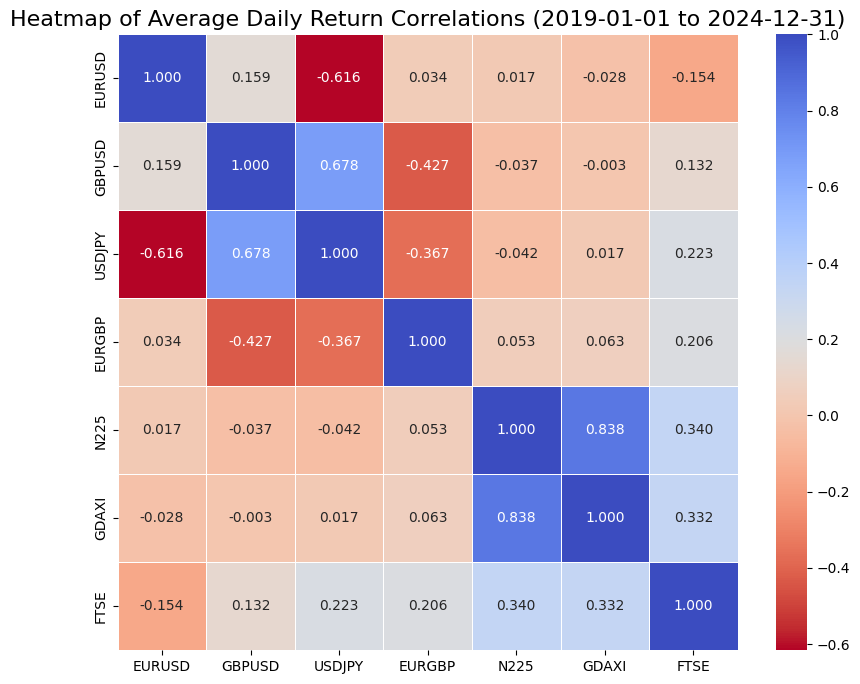


--- Generating Rolling Correlation Plot ---


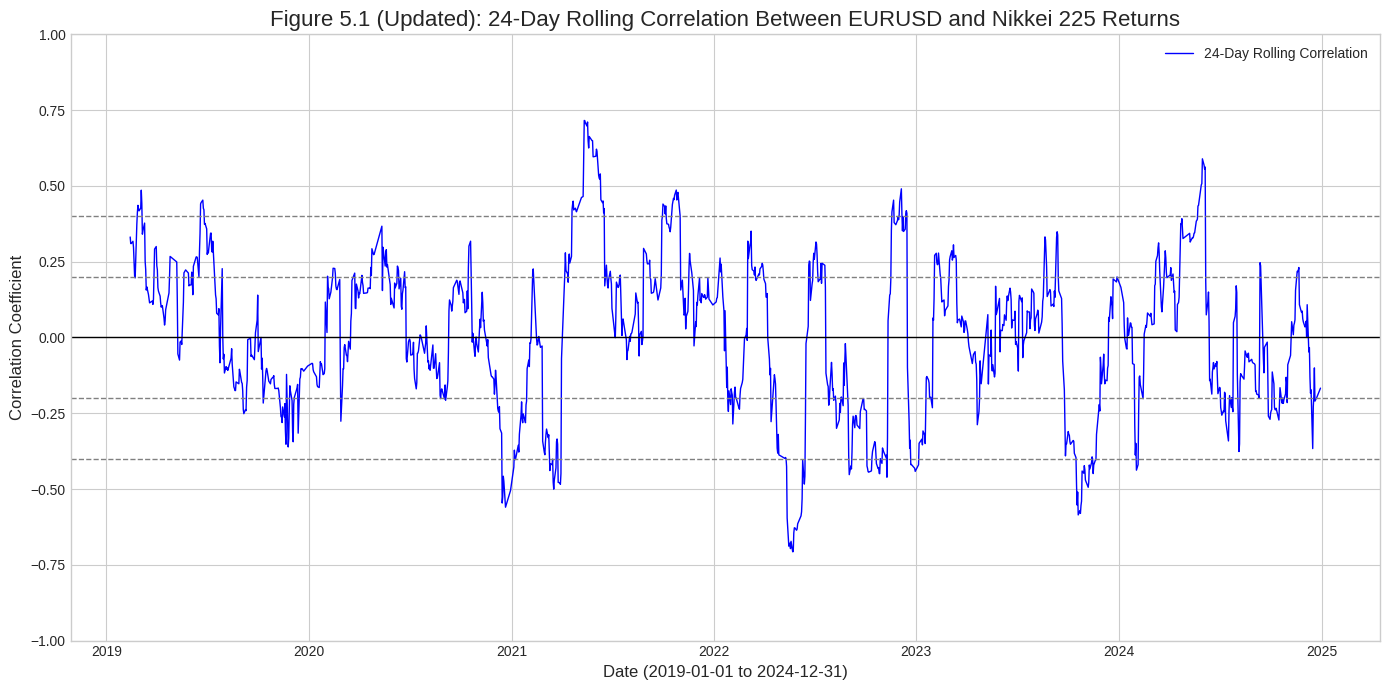

In [ ]:
# ==============================================================================
# Step 1: Install and Import Necessary Libraries
# ==============================================================================
# yfinance for downloading financial data
# scipy for statistical calculations (p-values)
#!pip install yfinance -q
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# ==============================================================================
# Step 2: Define Parameters
# ==============================================================================
# Define the list of tickers for FX pairs and Equity Indices
# Note: yfinance uses '=X' for currency pairs and '^' for many indices.
tickers = {
    'EURUSD': 'EURUSD=X',
    'GBPUSD': 'GBPUSD=X',
    'USDJPY': 'USDJPY=X',
    'EURGBP': 'EURGBP=X',
    'N225': '^N225',      # Nikkei 225
    'GDAXI': '^GDAXI',    # DAX PERFORMANCE-INDEX
    'FTSE': '^FTSE'       # FTSE 100
}

# --- THIS IS THE UPDATED PART ---
# Define the sample period for the full analysis
start_date = '2019-01-01'
end_date = '2024-12-31'
# --- END OF UPDATE ---

# Define the window for the rolling correlation
rolling_window = 24

# ==============================================================================
# Step 3: Download and Prepare the Data
# ==============================================================================
print(f"Downloading daily price data from {start_date} to {end_date}...")

# Download adjusted closing prices for all tickers
data = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']

# Rename columns to be more readable (e.g., 'EURUSD=X' to 'EURUSD')
data.columns = tickers.keys()

# Calculate daily log returns
log_returns = np.log(data / data.shift(1))

# Drop any rows with missing values that result from the shift operation
log_returns.dropna(inplace=True)

print("\n--- First 5 rows of calculated log returns ---")
print(log_returns.head())
print(f"\nTotal trading days in sample (N): {len(log_returns)}")

# ==============================================================================
# Step 4: Generate Correlation Matrix (Table 5.1)
# ==============================================================================
print("\n--- Generating Correlation Matrix with Significance ---")

# Create an empty DataFrame to store the results
corr_matrix_text = pd.DataFrame(index=log_returns.columns, columns=log_returns.columns)

# Calculate correlation and p-value for each pair of assets
for r in log_returns.columns:
    for c in log_returns.columns:
        # Calculate Pearson correlation and p-value
        corr, p_value = pearsonr(log_returns[r], log_returns[c])

        # Determine significance stars based on p-value
        stars = ''
        if p_value < 0.01:
            stars = '***'
        elif p_value < 0.05:
            stars = '**'
        elif p_value < 0.10:
            stars = '*'

        # Format the text string
        corr_matrix_text.loc[r, c] = f"{corr:.3f}{stars}"

# Display the formatted table
print(f"\nTable 5.1 (Updated): Average Daily Return Correlations ({start_date} to {end_date})")
print(corr_matrix_text.to_string())


# --- Create a visual heatmap for better interpretation ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    log_returns.corr(),
    annot=True,
    fmt=".3f",
    cmap='coolwarm_r', # Use a red-blue colormap
    linewidths=.5
)
plt.title(f'Heatmap of Average Daily Return Correlations ({start_date} to {end_date})', fontsize=16)
plt.show()


# ==============================================================================
# Step 5: Generate Rolling Correlation Chart (Figure 5.1)
# ==============================================================================
print("\n--- Generating Rolling Correlation Plot ---")

# Calculate the rolling correlation between EURUSD and Nikkei 225
rolling_corr = log_returns['EURUSD'].rolling(window=rolling_window).corr(log_returns['N225'])

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean plot style
plt.figure(figsize=(14, 7))

# Plot the rolling correlation data
plt.plot(rolling_corr.index, rolling_corr, label=f'{rolling_window}-Day Rolling Correlation', color='b', linewidth=1.0)

# Add horizontal reference lines as requested in the thesis
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axhline(0.2, color='grey', linestyle='--', linewidth=1)
plt.axhline(-0.2, color='grey', linestyle='--', linewidth=1)
plt.axhline(0.4, color='grey', linestyle='--', linewidth=1)
plt.axhline(-0.4, color='grey', linestyle='--', linewidth=1)

# Set plot title and labels
plt.title(f'Figure 5.1 (Updated): {rolling_window}-Day Rolling Correlation Between EURUSD and Nikkei 225 Returns', fontsize=16)
plt.xlabel(f'Date ({start_date} to {end_date})', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

# Set y-axis limits to the standard correlation range
plt.ylim(-1, 1)

# Add legend and display the plot
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
### FX equity Robustness Check



=== 15-day window ===
  Range:  -0.759 to 0.836
  Mean:   0.003


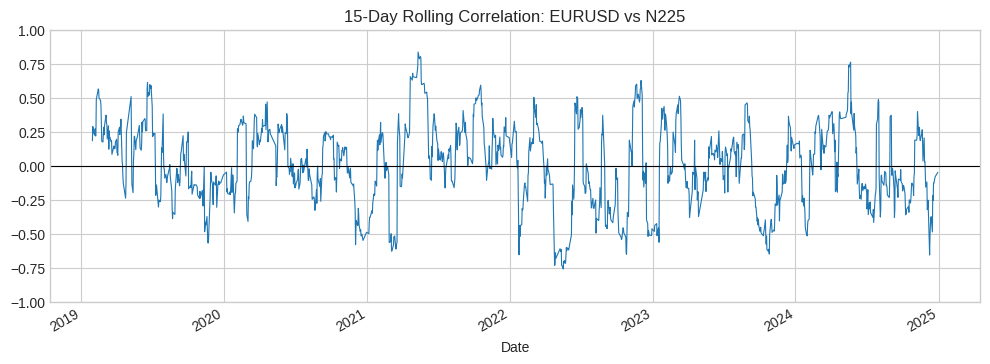


=== 30-day window ===
  Range:  -0.656 to 0.619
  Mean:   0.006


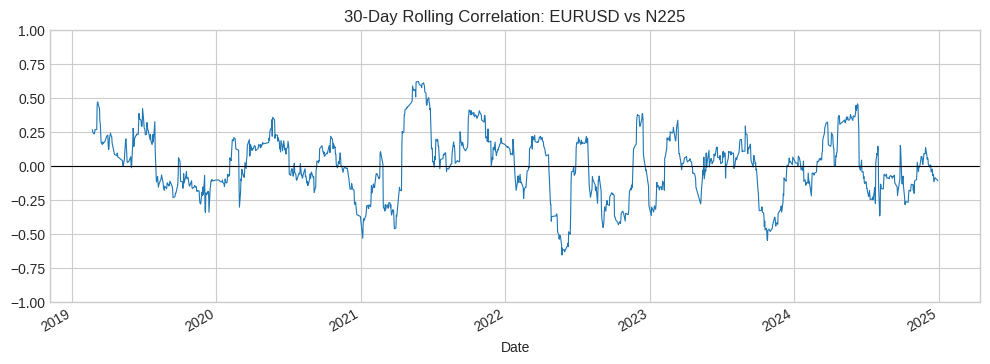

In [ ]:
# ==============================================================
# Alternative rolling windows: 15-day and 30-day
# ==============================================================

alt_windows = [15, 30]              # horizons to test
pair_a, pair_b = 'EURUSD', 'N225'   # reuse the same series as Fig. 5.1

results = {}

for w in alt_windows:
    rolling = log_returns[pair_a].rolling(window=w).corr(log_returns[pair_b])
    results[w] = rolling

    # Summary statistics
    print(f'\n=== {w}-day window ===')
    print(f'  Range:  {rolling.min():.3f} to {rolling.max():.3f}')
    print(f'  Mean:   {rolling.mean():.3f}')
    # quick visual
    rolling.plot(figsize=(12,4), lw=0.8,
                 title=f'{w}-Day Rolling Correlation: {pair_a} vs {pair_b}')
    plt.axhline(0, color='black', lw=0.8); plt.ylim(-1,1); plt.show()

# If you want to access the series later:
#results[15]  -> 15-day rolling correlation
#results[30]  -> 30-day rolling correlation


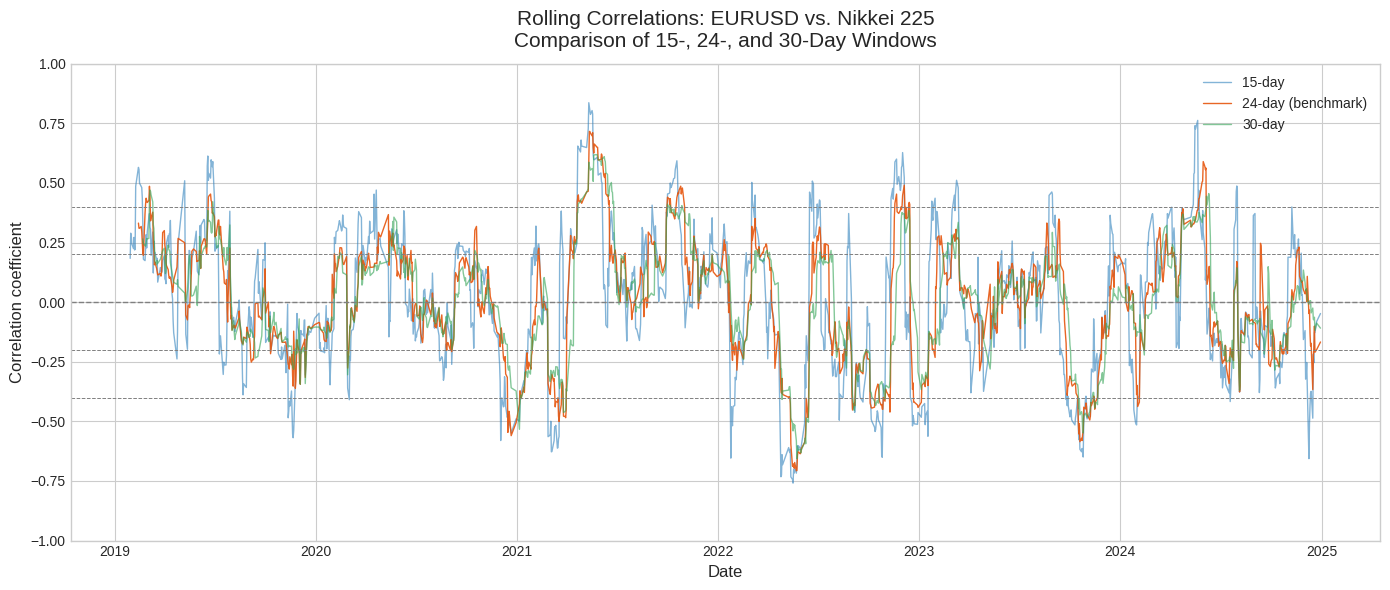

In [ ]:
# ==============================================================
# Overlay plot: 15-, 24-, and 30-day rolling correlations
# ==============================================================

import matplotlib.pyplot as plt

windows = [15, 24, 30]
labels  = {15: '15-day', 24: '24-day (benchmark)', 30: '30-day'}
colours = {15: '#3182bd', 24: '#e6550d', 30: '#31a354'}   # blue, orange, green

plt.figure(figsize=(14, 6))
for w in windows:
    roll = log_returns['EURUSD'].rolling(window=w).corr(log_returns['N225'])
    plt.plot(roll.index, roll,
             label=labels[w],
             color=colours[w],
             linewidth=1.0,
             alpha=0.9 if w==24 else 0.6)

# reference lines
for y in [0,  0.4, -0.4,  0.2, -0.2]:
    plt.axhline(y, color='grey', linestyle='--', linewidth=0.7 if y else 1.0)

plt.title('Rolling Correlations: EURUSD vs. Nikkei 225\nComparison of 15-, 24-, and 30-Day Windows',
          fontsize=15, pad=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Correlation coefficient', fontsize=12)
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
# ① make sure the newest nbconvert + webpdf extras are installed
!pip install -q --upgrade "nbconvert[webpdf]>=7.10.0"

# ② export the notebook (code + outputs) to HTML
!jupyter nbconvert \
        --to html \
        --output=/content/Data_Prep.html \
        /content/Data_Prep.ipynb

# ③ export the same notebook to PDF via the WebPDF exporter
#    (adds ~100 MB once for headless Chromium; allow a minute or two)
!jupyter nbconvert \
        --to webpdf \
        --allow-chromium-download \
        --output=/content/Data_Prep.pdf \
        /content/Data_Prep.ipynb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 51.9 MB/s eta 0:00:00
[NbConvertApp] WARNING | pattern '/content/Data_Prep.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions